# Trapezoidal extraction compare to box

## Imports

In [1]:
# Imports for plots

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

# Imports froom standard packages

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.sparse import identity
from astropy.io import fits
import numpy as np

# Imports for extraction

from extract.overlap import TrpzOverlap
from extract.utils import grid_from_map
from extract.throughput import ThroughputSOSS

# Local imports
from simulation_utils import load_simu, add_noise

## Class for tests

In [2]:
from extract.utils import grid_from_map

In [3]:
from extract.overlap import TrpzBox

In [4]:
from extract.utils import get_lam_p_or_m

In [5]:
from scipy.interpolate import interp1d

In [6]:
def box_extract(box_weights, data, lam_col, cols=None):

    if cols is None:
        cols = slice(None)
        
    box_weights = box_weights[:, cols].copy()
    data = data[:, cols].copy()
        
    out = np.ones_like(lam_col) * np.nan
    
    mask_nan = np.isnan(data)
    

    box_weights[mask_nan] = np.nan
    
    norm = np.nansum(box_weights**2, axis=0)
    idx = norm > 0
    
    out[idx] = np.nansum(box_weights*data, axis=0)[idx]    
    out[idx] /= norm[idx]
    
    i_sort = np.argsort(lam_col)
    
    return lam_col[i_sort], out[i_sort]

def rectify_tilt(wave_map, data, wave_grid, cols=None, unflip=False, kind='linear',
                 bounds_error=False, fill_value='extrapolate'):
    
    if cols is None:
        cols = slice(None)
    
    d_wave = np.diff(wave_map, axis=-1)
    if (d_wave <= 0).all():
        flipped = True
    else:
        flipped = False
        
    if flipped:
        wave_map = np.flip(wave_map, axis=-1)
        data = np.flip(data, axis=-1)
    
    n_row, n_col = data.shape
    data_rectified = np.ones_like(data) * np.nan
    for idx_row in range(n_row):
        wv, val = wave_map[idx_row], data[idx_row]
        spl_kwargs = {'kind': 'linear',
                      'bounds_error': False,
                      'fill_value': 'extrapolate'}
        fct = interp1d(wv, val, **spl_kwargs)
        val_grid = fct(wave_grid)
        data_rectified[idx_row, cols] = val_grid
        
    if flipped and not unflip:
        data_rectified = np.flip(data_rectified, axis=-1)
        
    return data_rectified
        

In [7]:
class TestsBoxTrpz:
    
    def __init__(self, wave_map, spat_pro, simu, box_width=20, tilted=False,
                 bin_limits=None, grid_trpz=None, wave_grid=None, wv_cols=None):
        
        scidata = simu["data"]
        self.f_th = simu["f_c1"] * ThroughputSOSS(1)(simu['grid_c1'])
        self.simu_grid = simu['grid_c1']
        self.scidata = scidata
        
        # Define wavelength grid
        if wave_grid is None:
            wave_grid, wv_cols = grid_from_map(wave_map, spat_pro, out_col=True)
        
        # Define bins and grid for trpz extraction
        if bin_limits is None:
            lam_p, lam_m = get_lam_p_or_m(wave_grid)
            lam_p, lam_m = np.sort(lam_p), np.sort(lam_m)
            bin_limits = [lam_m, lam_p]
        
        if grid_trpz is None:
            grid_trpz = np.concatenate([bin_limits[0], [bin_limits[1][-1]]])
        
        extra_trpz = TrpzBox(spat_pro, wave_map, lam_grid=grid_trpz, box_width=box_width)
        f_k = extra_trpz.extract(data=scidata)
        bin_center, f_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=f_k)
        
        self.f_k = f_k
        self.f_bin = f_bin
        self.bin_center = bin_center
        self.bin_limits = bin_limits
        self.grid_trpz = grid_trpz
        self.data_rect = None
        self.wave_grid = wave_grid
        self.wv_cols = wv_cols
        
        if tilted:
            box_weights = extra_trpz.get_aperture_weights(spat_pro, n_pix=box_width)
            data_rect = rectify_tilt(wave_map, scidata, wave_grid, cols=wv_cols)
            self.data_rect = data_rect
            grid_box, f_box = box_extract(box_weights, data_rect, np.flip(wave_grid), cols=wv_cols)
        else:
            box_weights = extra_trpz.get_aperture_weights(spat_pro, n_pix=box_width)
            grid_box, f_box = box_extract(box_weights, scidata, np.flip(bin_center), cols=wv_cols)
        
        self.grid_box = grid_box
        self.f_box = f_box
        
    def plot_comparison(self):
        
        grid_trpz = self.grid_trpz
        f_k = self.f_k
        f_th = self.f_th
        simu_grid = self.simu_grid
        bin_center = self.bin_center
        f_bin = self.f_bin
        f_box = self.f_box
        
        fig, ax = plt.subplots(2,1,sharex=True)

        ax[0].set_title('Order 1')
        ax[0].plot(grid_trpz, f_k, ".", label="Trpz box")
        ax[0].plot(simu_grid, f_th,
                   label="(Injected flux) x (Throughput)")
        ax[0].legend()

        ax[1].plot(bin_center, f_bin, label="Trpz box")
        ax[1].plot(bin_center, f_box, "--", label="Box extract")
        ax[1].legend()

        ax[0].set_ylabel('f_k')
        ax[1].set_ylabel('f_bin')
        plt.xlabel('Wavelength')
        
        return fig, ax
    
    def plot_error(self, f_truth=None, to_compare='f_bin'):
        
        bin_center = self.bin_center
        f_comp = getattr(self, to_compare)
        if f_truth is None:
            f_truth = self.f_box
        
        fig, ax = plt.subplots(2,1,sharex=True)

        ax[0].set_title('Order 1')
        ax[0].plot(bin_center, f_comp, label=to_compare)
        ax[0].plot(bin_center, f_truth, "--", label="Truth")
        ax[0].legend()

        ax[1].plot(bin_center, (f_comp-f_truth)/f_truth*1e6, ".")

        ax[0].set_ylabel('f_bin')
        ax[1].set_ylabel('Relative Error [ppm]')
        plt.xlabel('Wavelength')
        
        return fig, ax

In [8]:
from extract.utils import oversample_grid
from extract.overlap import TrpzOverlap, fct_ones

In [9]:
class TestExtractSingleOrd:
    
    def __init__(self, scidata, wave_map, spat_pro, f_th, grid_f_th, order,
                 factors=None, i_plot=True, n_os=1, tikho_kwargs=None, uncert=None, 
                 bin_limits=None, grid_trpz=None, wave_grid=None, wv_cols=None, name=None,
                 wv_range=None, **kwargs):

        self.f_th = f_th
        self.simu_grid = grid_f_th
        self.scidata = scidata
        
        if name is None:
            name = ''
        self.name = name
        
        if uncert is None:
            uncert = np.ones_like(scidata)
            self.noisy = False
        else:
            self.noisy = True
        self.uncert = uncert

        # Define wavelength grid
        if wave_grid is None:
            wave_grid, wv_cols = grid_from_map(wave_map, spat_pro, out_col=True)
            
        if wv_range is not None:
            idx = (wv_range[0] <= wave_grid)
            idx &= (wave_grid <= wv_range[1])
            wave_grid = wave_grid[idx]
            wv_cols = wv_cols[idx]

        # Define bins and grid for trpz extraction
        if bin_limits is None:
            lam_p, lam_m = get_lam_p_or_m(wave_grid)
            lam_p, lam_m = np.sort(lam_p), np.sort(lam_m)
            bin_limits = [lam_m, lam_p]

        if grid_trpz is None:
            grid_trpz = np.concatenate([bin_limits[0], [bin_limits[1][-1]]])
            grid_trpz = oversample_grid(grid_trpz, n_os)

        # Init extraction of a single order
        extra_trpz = TrpzOverlap([spat_pro], [wave_map], [fct_ones], [np.array([1])],
                     lam_grid=grid_trpz, orders=[order], **kwargs)

        # Extraction
        if factors is None:
            # Extract without tikhonov
            f_k = extra_trpz.extract(data=scidata, sig=uncert)
        else:
            # First search for best factor
            tikho_tests = extra_trpz.get_tikho_tests(factors, data=scidata,
                                                     sig=uncert, tikho_kwargs=tikho_kwargs)
            best_fac = extra_trpz.best_tikho_factor(tikho_tests, i_plot=i_plot)
            # Save these tests
            tikho_tests_saved = tikho_tests
            # Second search finer
            # Refine the grid (span 4 orders of magnitude).
            best_fac = np.log10(best_fac)
            factors = np.logspace(best_fac-2, best_fac+2, 20)

            # No need to specify `data` and `sig` again. 
            tests = extra_trpz.get_tikho_tests(factors, data=scidata,
                                               sig=uncert, tikho_kwargs=tikho_kwargs)
            best_fac = extra_trpz.best_tikho_factor(tests=tests, i_plot=i_plot)
            f_k = extra_trpz(data=scidata, tikhonov=True, factor=best_fac,
                             tikho_kwargs=tikho_kwargs)
            
            # Save Binned tikho tests
            idx = np.isfinite(f_k)
            tikho_tests_binned = {'f_bin': []}
            tikho_tests_binned['factors'] = tikho_tests_saved['factors']
            for i_sln, fac in enumerate(tikho_tests_saved['factors']):
                sln = np.nan * f_k
                sln[idx] = tikho_tests_saved['solution'][i_sln]
                _, sln_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=sln)
                tikho_tests_binned['f_bin'].append(sln_bin)
            self.tikho_tests_binned = tikho_tests_binned

        # Bin extracted spectrum
        bin_center, f_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=f_k)

        # Binned theoretical 
        idx = (grid_f_th >= grid_trpz.min())  &  (grid_f_th <= grid_trpz.max())
        _, f_bin_th = extra_trpz.bin_to_pixel(grid_pix=bin_limits,
                                              f_k_c=f_th[idx],
                                              grid_f_k=grid_f_th[idx])
        # Rebuild detector
        rebuilt = extra_trpz.rebuild(f_k)
        
        # Theoretical photon noise
        phot_noise = extra_trpz.estim_noise()
        
        idx_spl = np.isfinite(phot_noise[1])
        noise_spl = interp1d(phot_noise[0][idx_spl], phot_noise[1][idx_spl],
                             kind='cubic', bounds_error=False, fill_value=np.nan)
        
        self.phot_noise = phot_noise
        self.phot_noise_spl = noise_spl

        self.f_bin_th = f_bin_th        
        self.f_k = f_k
        self.f_bin = f_bin
        self.bin_center = bin_center
        self.bin_limits = bin_limits
        self.grid_trpz = grid_trpz
        self.rebuilt = rebuilt
                                              
    def show_col_residuals(self, cols=None, fig=None, ax=None):
        
        scidata = self.scidata
        rebuilt = self.rebuilt
        uncert = self.uncert
        name = self.name
        
        if ax is None:
            if fig is None:
                fig, ax = plt.subplots(2, 1, sharex=True)
            else:
                ax = fig.axes
                
        if cols is None:
            cols = range(10, 20)
                
        residual = (rebuilt-scidata)/scidata*1e6
        for i_col in cols:
            ax[0].plot(residual[:,i_col], ".", label=i_col)
            ax[1].plot(((rebuilt-scidata)/uncert)[:,i_col], ".")
        ax[0].set_ylabel("Relative error [ppm]")
        ax[1].set_ylabel("Error [$\sigma$]")
        ax[0].set_title(name)
        
        return fig, ax
    
    def compare_binned(self, fig=None, ax=None, hist_kwargs=None, wv_range=None, f_bin=None):
        
        if f_bin is None:
            f_bin = self.f_bin
            
        f_bin_th = self.f_bin_th
        bin_center = self.bin_center
        name = self.name
        
        if wv_range is None:
            idx = slice(None)
        else:
            idx = (bin_center < wv_range[1])
            idx &= (wv_range[0] <= bin_center)
        f_bin_th = f_bin_th[idx]
        f_bin = f_bin[idx]
        bin_center = bin_center[idx]
        
        
        if ax is None:
            if fig is None:
                fig = plt.figure()
                # Upper left
                ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=3)
                # Lower left
                ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=3, sharex=ax1)
                # Lower right (histogram)
                ax3 = plt.subplot2grid((2, 4), (1, 3), sharey=ax2)
                ax3.yaxis.tick_right()
                ax = [ax1, ax2, ax3]
            else:
                ax = fig.axes
                
        if hist_kwargs is None:
            hist_kwargs = {}
        
        default_hist_kwargs = {'orientation': "horizontal",
                               'histtype': "step"}
        hist_kwargs = {**default_hist_kwargs, **hist_kwargs}
                
                
        rel_error = (f_bin-f_bin_th)/f_bin_th * 1e6
        
        
        ax[0].plot(bin_center, f_bin_th)
        ax[0].plot(bin_center, f_bin, "--")
        ax[1].plot(bin_center, rel_error, ".")
        
        ax[2].hist(rel_error, **hist_kwargs)
        
        if self.noisy:
            ax[1].plot(bin_center, self.phot_noise_spl(bin_center)*1e6, "--",
                       color='cyan', label='Photon noise')
            ax[1].plot(bin_center, -self.phot_noise_spl(bin_center)*1e6, "--",
                       color='cyan')
            ax[1].legend()
        

        ax[0].set_ylabel("Spectrum (binned)")
        ax[1].set_ylabel("Relative error [ppm]")
        ax[1].set_xlabel("Wavelength [microns]")
        ax[0].tick_params(labelbottom=False)
        ax[0].set_title(name)
        
        return fig, ax
     

    def compare_extracted(self, fig=None, ax=None):
        
        f_th = self.f_th
        f_k = self.f_k
        grid_trpz = self.grid_trpz
        simu_grid = self.simu_grid
        name = self.name
        
        if ax is None:
            if fig is None:
                fig, ax = plt.subplots(2, 1, sharex=True)
            else:
                ax = fig.axes
                
        f_th_spl = interp1d(simu_grid, f_th, kind='cubic',
                            bounds_error=False, fill_value=np.nan)
        f_th = f_th_spl(grid_trpz)
                
        ax[0].plot(grid_trpz, f_th)
        ax[0].plot(grid_trpz, f_k, "--")
        ax[1].plot(grid_trpz, (f_k-f_th)/f_th * 1e6, ".")

        ax[0].set_ylabel("Spectrum (f_k)")
        ax[1].set_ylabel("Relative error [ppm]")
        ax[1].set_xlabel("Wavelength [microns]")
        ax[0].set_title(name)
        
        return fig, ax
    
    def plot_spectra(self, fig=None, ax=None):
        
        f_th = self.f_th
        f_k = self.f_k
        f_bin_th = self.f_bin_th
        f_bin = self.f_bin
        bin_center = self.bin_center
        grid_trpz = self.grid_trpz
        simu_grid = self.simu_grid
        name = self.name
        
        if ax is None:
            if fig is None:
                fig, ax = plt.subplots(2, 1, sharex=True)
            else:
                ax = fig.axes
                
        ax[0].plot(simu_grid, f_th, label="Injected")
        ax[0].plot(grid_trpz, f_k, "--", label="Extracted")
        ax[1].plot(bin_center, f_bin_th)
        ax[1].plot(bin_center, f_bin, "--")

        ax[0].set_ylabel("Flux (f_k)")
        ax[1].set_ylabel("Integrated flux (f_binned)")
        ax[1].set_xlabel("Wavelength [microns]")
        ax[0].set_title(name)

        return fig, ax


class TestExtractFirstOrd(TestExtractSingleOrd):
    
    def __init__(self, wave_map, spat_pro, scidata=None, f_th=None, grid_f_th=None,
                 uncert=None, simu=None, thrpt=None, name=None,
                 factors=None, i_plot=True, n_os=1, tikho_kwargs=None,
                 bin_limits=None, grid_trpz=None, wave_grid=None, wv_cols=None, **kwargs):
        
        if thrpt is None:
            thrpt = ThroughputSOSS(1)
        
        if scidata is None:
            scidata = simu['data']

        if f_th is None:
            f_th = simu["f_c1"] * thrpt(simu['grid_c1'])

        if grid_f_th is None:
            grid_f_th = simu['grid_c1']
            
        order = 1
            
        args = (scidata, wave_map, spat_pro, f_th, grid_f_th, order)
        kwargs = {'uncert': uncert,
                  'factors': factors,
                  'i_plot': i_plot,
                  'n_os': n_os,
                  'tikho_kwargs': tikho_kwargs,
                  'bin_limits': bin_limits,
                  'grid_trpz': grid_trpz,
                  'wave_grid': wave_grid,
                  'wv_cols': wv_cols,
                  'name': name,
                  **kwargs}
        super().__init__(*args, **kwargs)


## smoothing spline function

In [10]:
from extract.regularisation import finite_first_d, finite_second_d, finite_zeroth_d
from scipy.sparse import diags

In [11]:
diags

<function scipy.sparse.construct.diags(diagonals, offsets=0, shape=None, format=None, dtype=None)>

In [114]:
def quadratic_smooth(grid):
    
    # Save length of the grid
    n_grid = len(grid)
    
    # Space between each nodes
    d_grid = np.diff(grid)
    
    #
    # Build matrix delta
    #
    # 3 diagonals
    diag_0 = 1/d_grid
    diag_1 = -1/d_grid[:-1] - 1/d_grid[1:]
    diag_2 = 1/d_grid[1:]
    # Shape of the matrix
    shape = (n_grid - 2, n_grid)
    # Build as a sparse matrix
    args = ([diag_0, diag_1, diag_2], [0, 1, 2])
    d_matrix = diags(*args, shape=shape)
    
    #
    # Build weights matrix
    #
    diag_0 = (d_grid[:-1] + d_grid[1:]) / 3
    diag_1 = d_grid[1:-1]/6
    # Shape of the matrix
    shape = (n_grid - 2, n_grid - 2)
    # Build as a sparse matrix
    args = ([diag_1, diag_0, diag_1], [-1, 0, 1])
    w_matrix = diags(*args, shape=shape)
    
    # Matrix product 
    mat_prod = d_matrix.T.dot(w_matrix)
    mat_prod = mat_prod.dot(d_matrix)
    
    return mat_prod

def linear_smooth(grid):
    
    # Save length of the grid
    n_grid = len(grid)
    
    # Space between each nodes
    d_grid = np.diff(grid)
    
    #
    # Build matrix delta
    #
    d_mat = finite_first_d(grid)
    
    return d_mat.T.dot(d_mat)
    

In [116]:
linear_smooth(np.arange(5)).toarray()

array([[ 1., -1.,  0.,  0.,  0.],
       [-1.,  2., -1.,  0.,  0.],
       [ 0., -1.,  2., -1.,  0.],
       [ 0.,  0., -1.,  2., -1.],
       [ 0.,  0.,  0., -1.,  1.]])

## Load ref files

In [57]:
tilted = False

In [58]:
DEFAULT_PATH = '../jwst-mtl/SOSS/extract/'
DEFAULT_REF_FILES = {'wv_1': 'Ref_files/wavelengths_m1.fits',
                     'wv_2': 'Ref_files/wavelengths_m2.fits',
                     'P_1': 'Ref_files/spat_profile_m1.fits',
                     'P_2': 'Ref_files/spat_profile_m2.fits'}

# Read relevant files
wv_1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_1"])[0].data
wv_2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_2"])[0].data
P1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_1"])[0].data.squeeze()
P2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_2"])[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

if not tilted:
    # Remove the tilt from wv maps
    wv_1 = np.tile(wv_1[50,:], (256, 1))
    wv_2 = np.tile(wv_2[50,:], (256, 1))

## Load simu

In [59]:
# Load a simulation

if tilted:
    simu = load_simu("../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker.fits", order=1, noisy=False)
#     simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e-01.fits", order=1, noisy=False)
else:
    simu = load_simu("../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker_notilt.fits", order=1, noisy=False)
#     simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e+01_no-tilt.fits", order=1, noisy=False)
scidata = simu["data"]

<IPython.core.display.Javascript object>


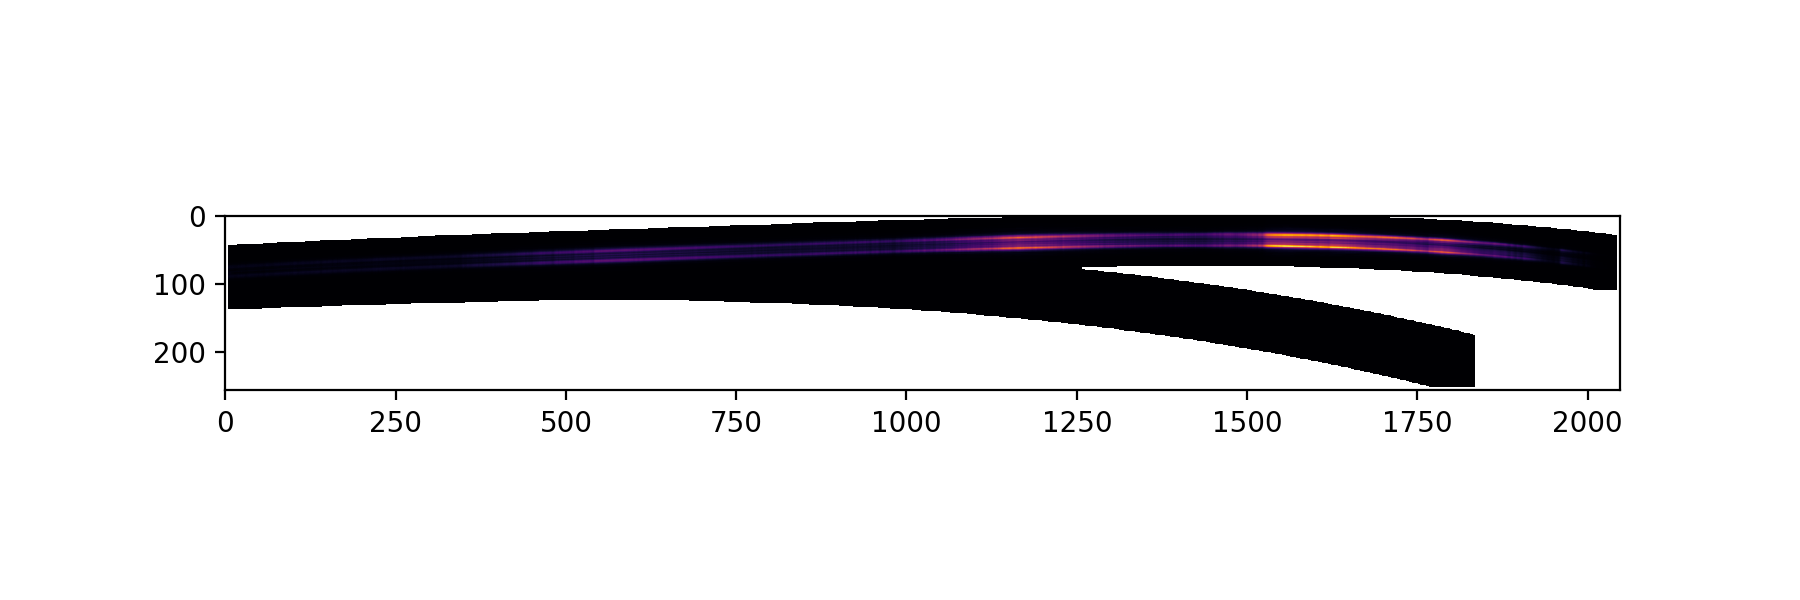

In [13]:
plt.imshow(simu['data'])

In [46]:
test_extract_os = TestExtractFirstOrd(wv_1, P1, simu=simu, n_os=1, name='no-tikho_not-tilted_os=1')

<IPython.core.display.Javascript object>


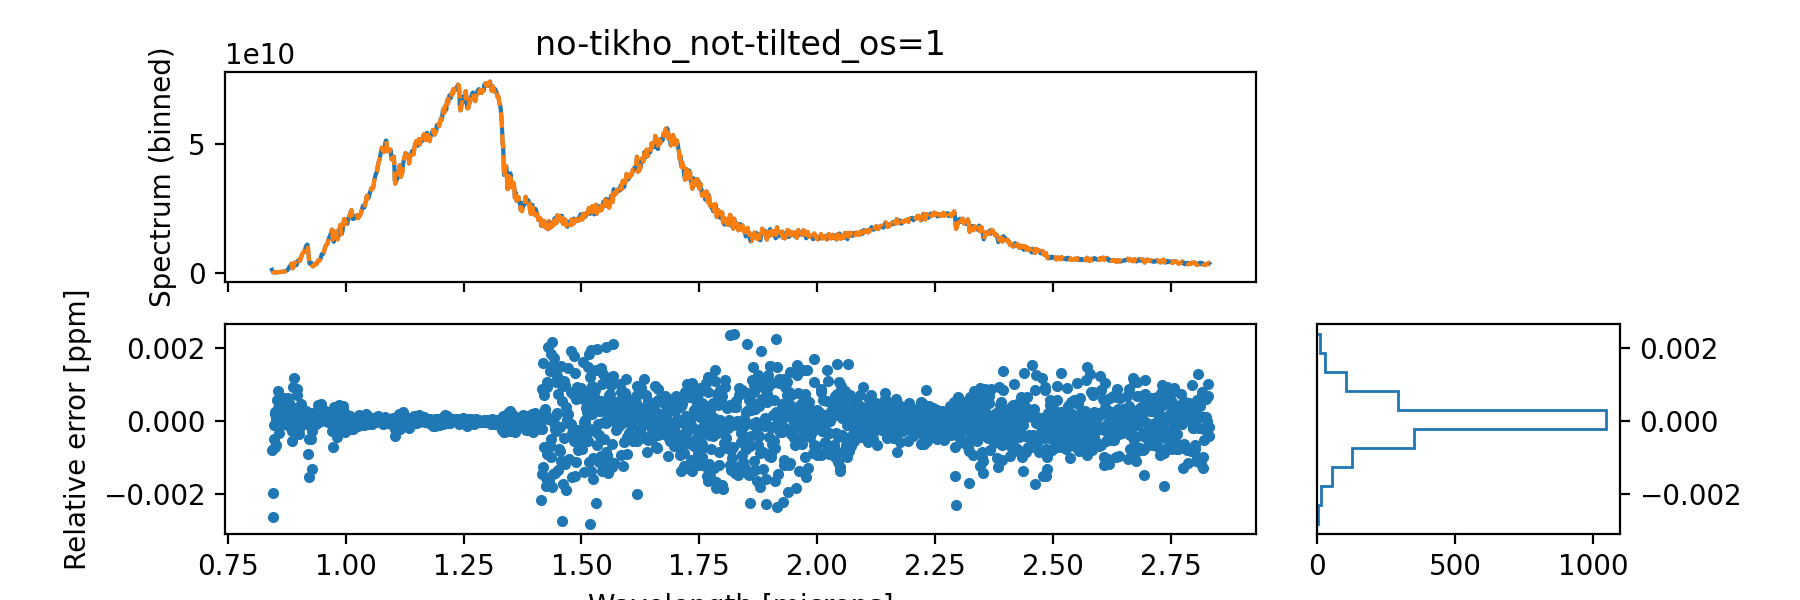

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(<Figure size 900x300 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f9660e48950>])

In [47]:
test_extract_os.compare_binned()
# fig.savefig('Tikho_tests/no-tikho_not-tilted_os=1.png')

In [60]:
estimate = interp1d(simu["grid_c1"], simu["f_c1"]*ThroughputSOSS(1)(simu["grid_c1"]), kind="linear", 
                    bounds_error=False, fill_value='extrapolate')

In [61]:
def get_tikho_matrix(grid, mode=None):
    
    if mode == 'zeroth':
        t_mat = finite_zeroth_d(grid)
    elif mode == 'first_d-wave':
         t_mat = finite_first_d(grid)
    elif mode == 'first_no-d-wave':
        t_mat = finite_first_d(np.arange(len(grid)))
    elif mode == 'second_d-wave':
        t_mat = finite_second_d(grid)
    elif mode == 'second_no-d-wave':
        t_mat = finite_second_d(np.arange(len(grid)))
    elif mode == 'quad_smooth':
        t_mat = quadratic_smooth(grid)
    else:
        raise ValueError('Mode not valid')
    
#     # Weights according to 'kunasz1973'
#     tikho_factor_scale = np.power(estimate(grid), -2)
#     tikho_factor_scale /= np.sum(tikho_factor_scale)

#     if 'first' in mode:
#         t_mat = diags(tikho_factor_scale[:-1]).dot(t_mat)
#     elif 'second' in mode:
#         t_mat = diags(tikho_factor_scale[1:-1]).dot(t_mat)
#     else:
#         t_mat = diags(tikho_factor_scale).dot(t_mat)
    return t_mat


Testing factors...
20/20


<IPython.core.display.Javascript object>


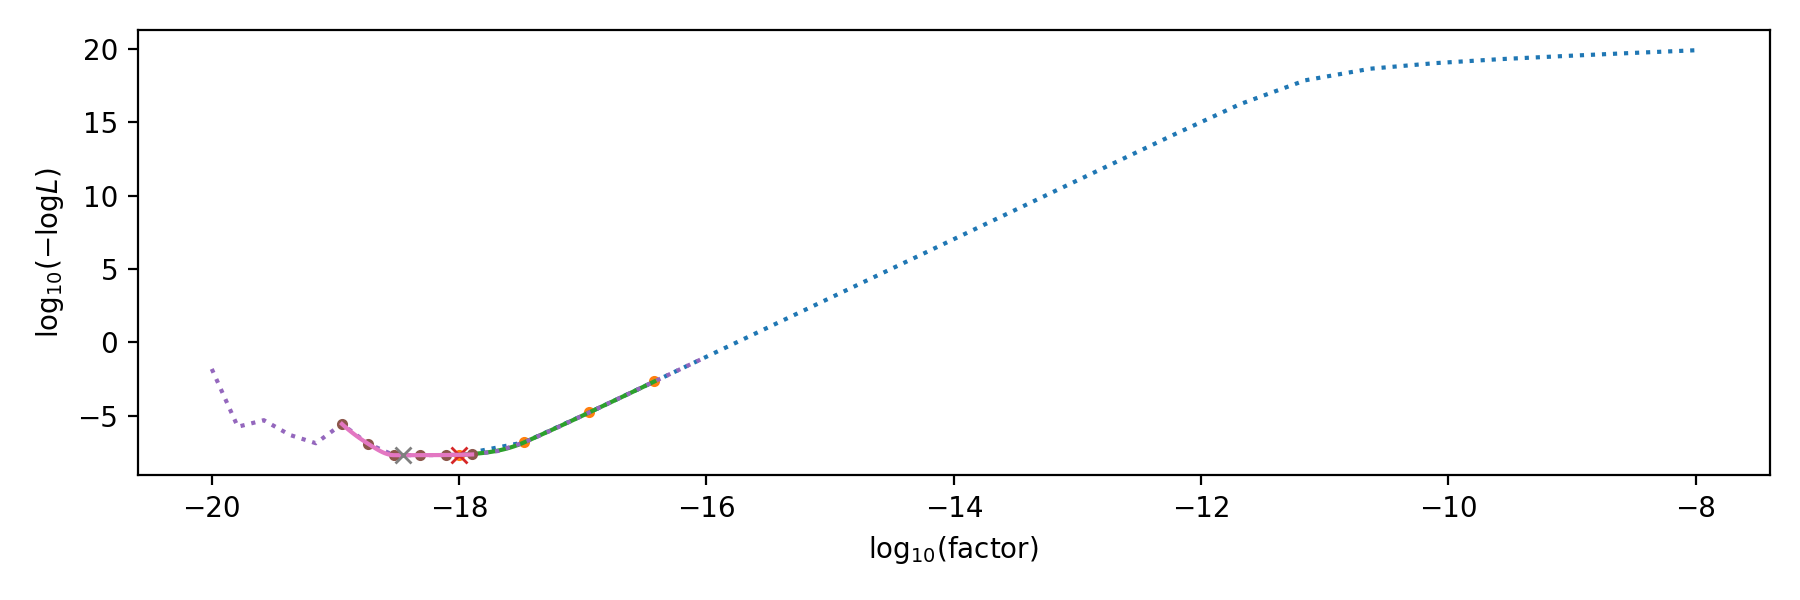

Testing factors...
20/20


In [62]:
# n_os = 5
for n_os in [5]:
    mode = 'quad_smooth'
    name = f'9000K_os={n_os}_' + mode
    if tilted:
        name += '_tilted'
    else:
        name += '_not-tilted'


    tikho_kwargs = {"t_mat":lambda x:get_tikho_matrix(x, mode=mode)}

    factors = np.logspace(-18, -8, 20)
    test_extract_os = TestExtractFirstOrd(wv_1, P1, simu=simu, n_os=n_os, name=name,
                                          factors=factors, tikho_kwargs=tikho_kwargs)
#     plt.close()
    
#     fig, ax = test_extract_os.compare_binned()
#     fig.savefig('Tikho_tests/'+name+'.png')
#     plt.close()

<IPython.core.display.Javascript object>


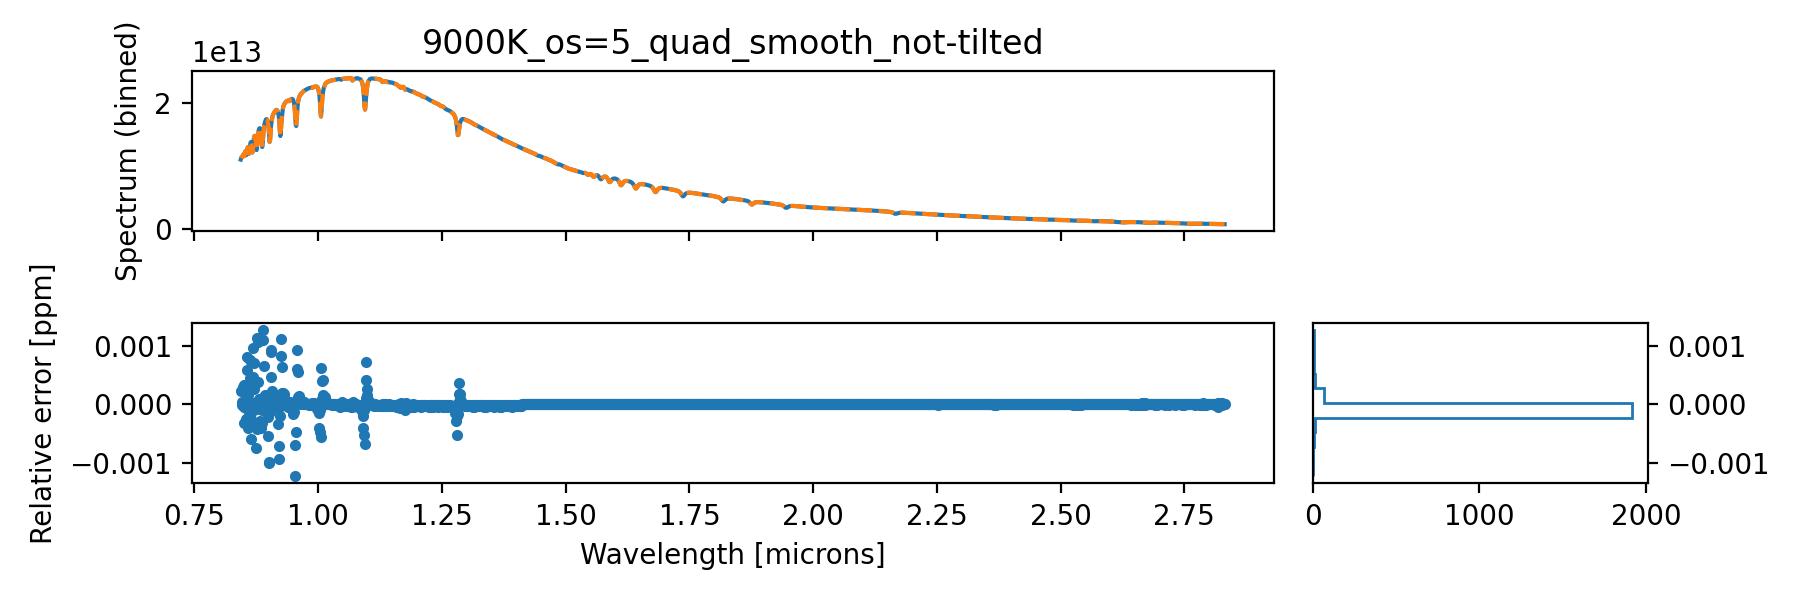

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [63]:
fig, ax = test_extract_os.compare_binned()#wv_range=[0.7, 1.3])
plt.tight_layout()
# fig.savefig('Tikho_tests/'+name+'.png')

## Test not tilted

In [12]:
test_1 = TestsBoxTrpz(wv_1, P1, simu, box_width=30, tilted=False)

## Compare

<IPython.core.display.Javascript object>


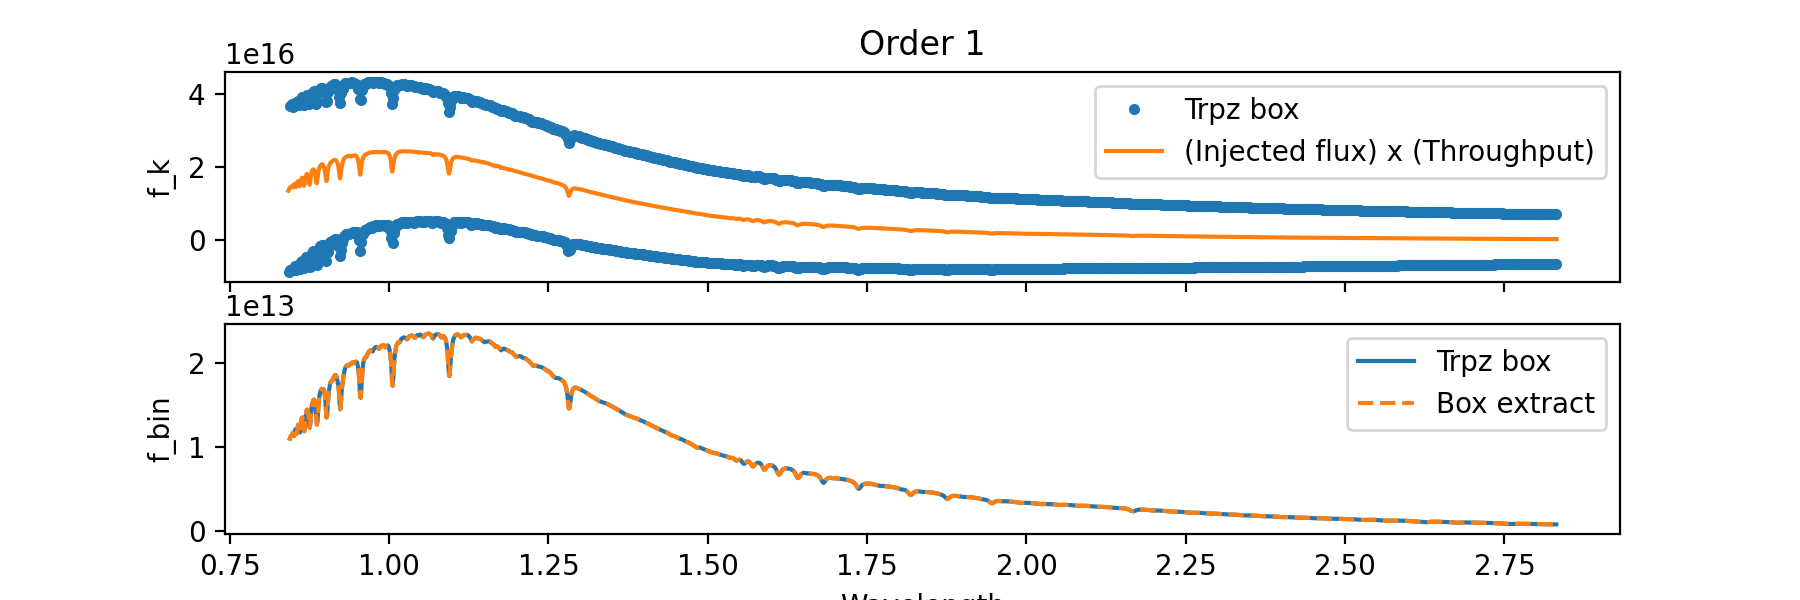

(<Figure size 900x300 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facc4141590>,
       dtype=object))

In [13]:
test_1.plot_comparison()

<IPython.core.display.Javascript object>


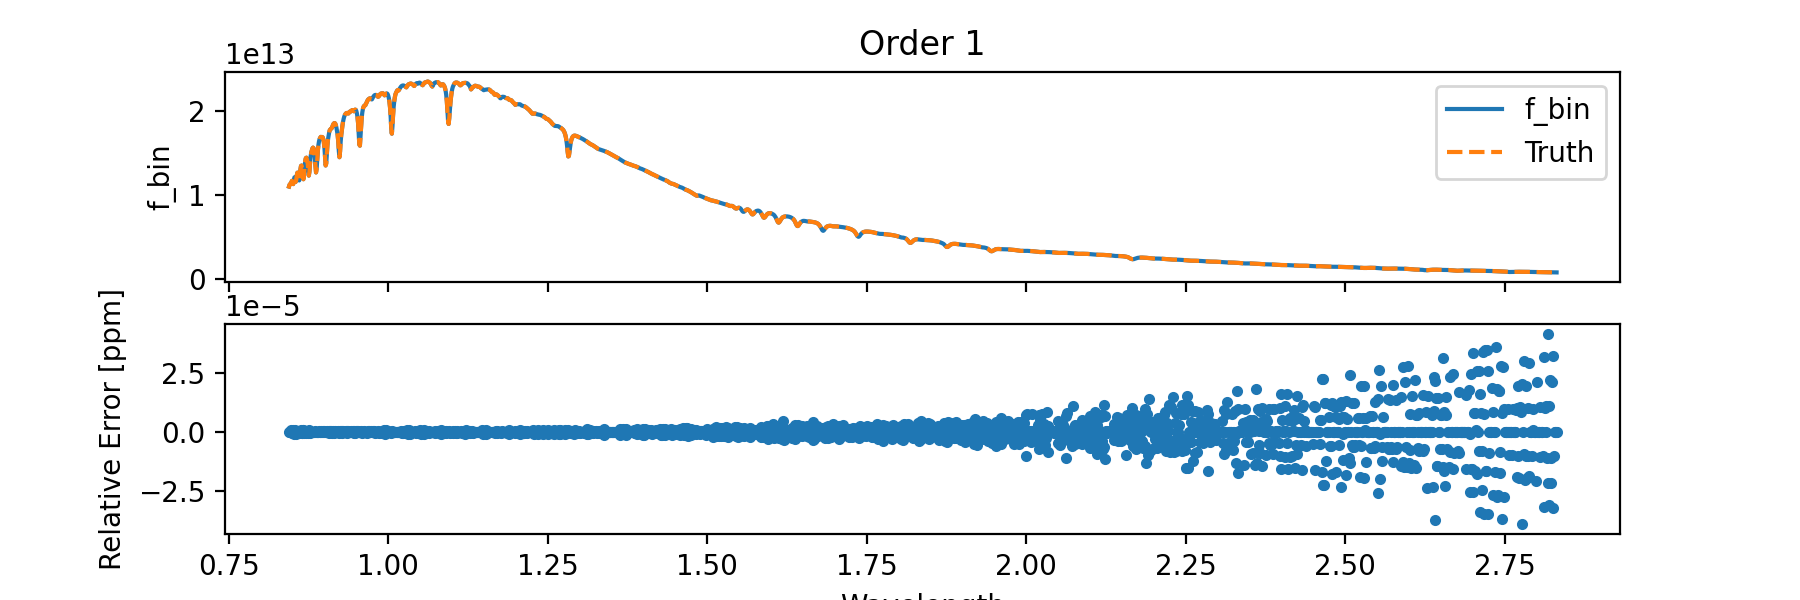

(<Figure size 900x300 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facc22c16d0>,
       dtype=object))

In [14]:
test_1.plot_error()

## Box tilted

In [140]:
tilted=True

In [141]:
# Read relevant files
wv_1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_1"])[0].data
wv_2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["wv_2"])[0].data
P1 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_1"])[0].data.squeeze()
P2 = fits.open(DEFAULT_PATH + DEFAULT_REF_FILES["P_2"])[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
P1 = P1.astype(float)
P2 = P2.astype(float)

if not tilted:
    # Remove the tilt from wv maps
    wv_1 = np.tile(wv_1[50,:], (256, 1))
    wv_2 = np.tile(wv_2[50,:], (256, 1))

In [142]:
# Load a simulation

if tilted:
#     simu = load_simu("../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker.fits", order=1, noisy=False)
    simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e-01.fits", order=1, noisy=False)
else:
#     simu = load_simu("../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_cutker_notilt.fits", order=1, noisy=False)
    simu = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e+01_no-tilt.fits", order=1, noisy=False)
scidata = simu["data"]

In [18]:
test_2 = TestsBoxTrpz(wv_1, P1, simu, box_width=30, tilted=True,
                      bin_limits=test_1.bin_limits, grid_trpz=test_1.grid_trpz,
                      wave_grid=test_1.wave_grid, wv_cols=test_1.wv_cols)

<IPython.core.display.Javascript object>


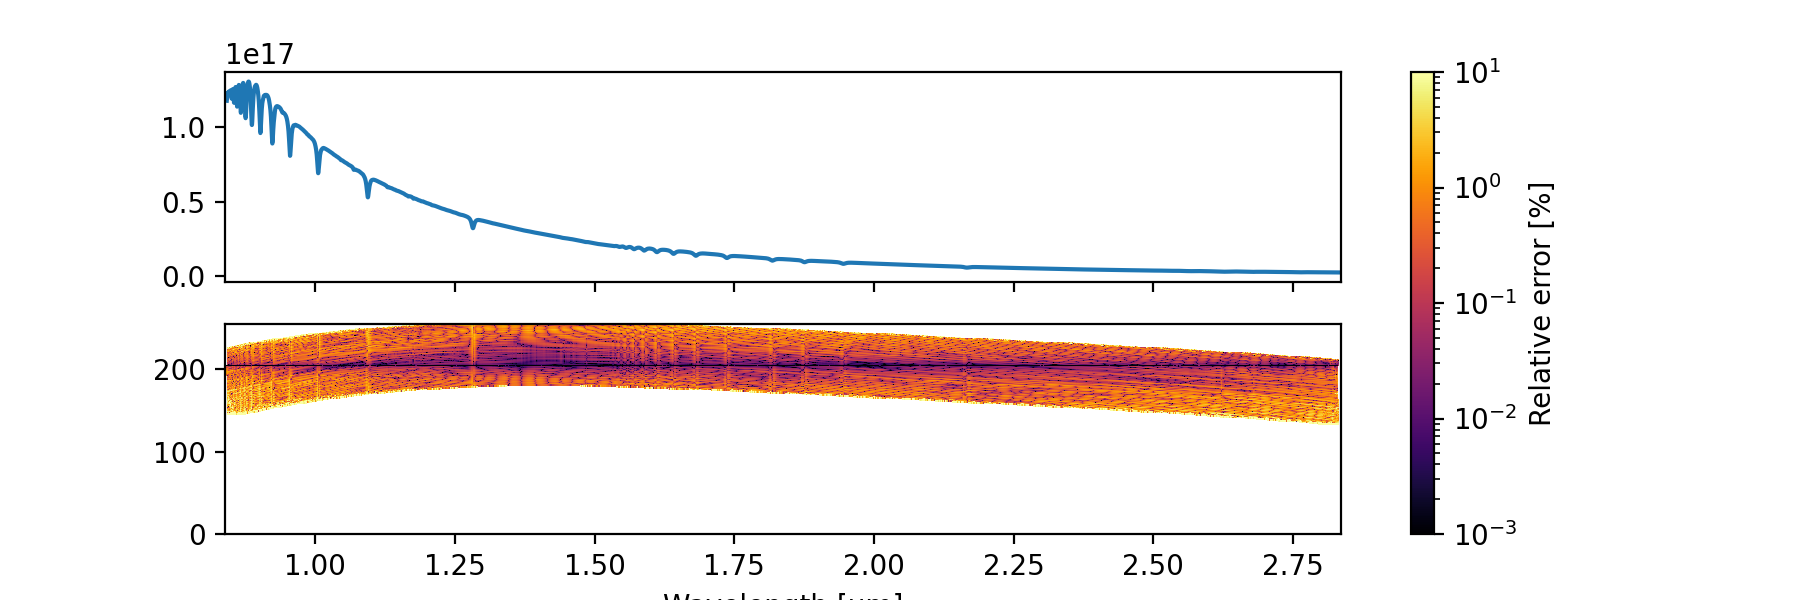

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 0, 'Wavelength [um]')

In [19]:
fig, ax = plt.subplots(2,1,sharex=True,)

ax[0].plot(simu['grid_c1'], simu['f_c1'])

im = ax[1].pcolormesh(wv_1[50,:], np.flip(np.arange(256)),
                      np.abs(test_2.data_rect-scidata)/scidata*100,
           norm=LogNorm(), vmin=1e-3, vmax=10)
plt.colorbar(im, ax=ax, label='Relative error [%]')

ax[1].set_xlabel("Wavelength [um]")

<IPython.core.display.Javascript object>


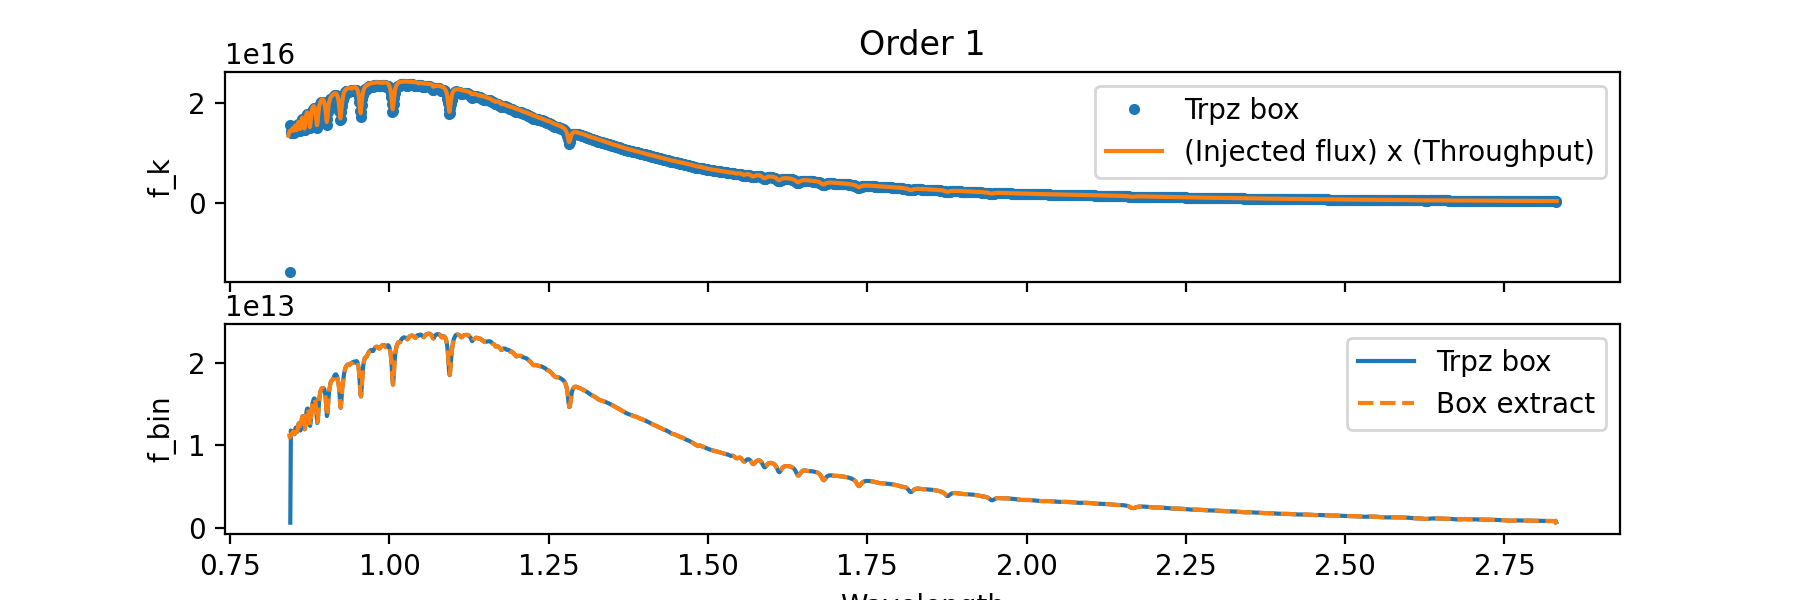

(<Figure size 900x300 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facae1bb8d0>,
       dtype=object))

In [20]:
test_2.plot_comparison()

<IPython.core.display.Javascript object>


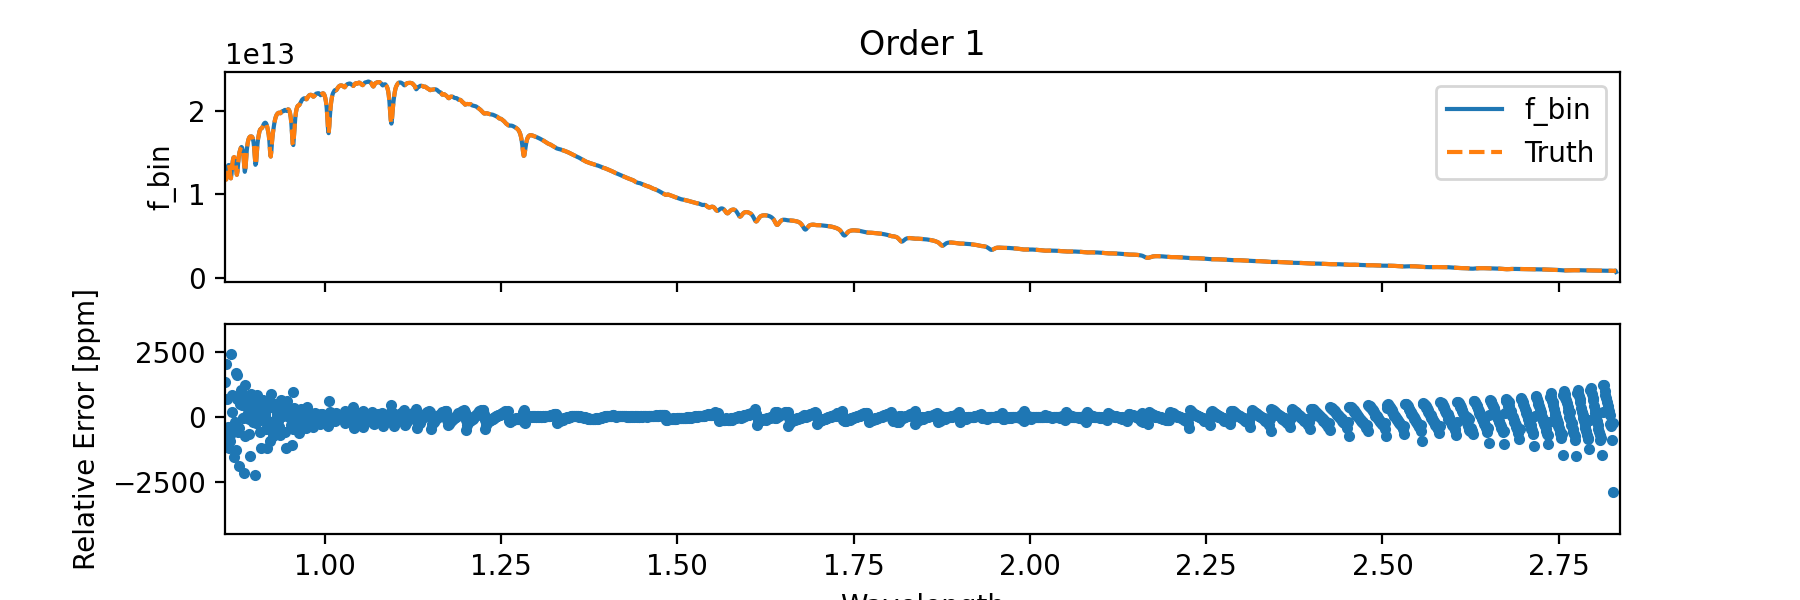

(<Figure size 900x300 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facaeb20090>,
       dtype=object))

In [21]:
test_2.plot_error(f_truth=test_1.f_box)

<IPython.core.display.Javascript object>


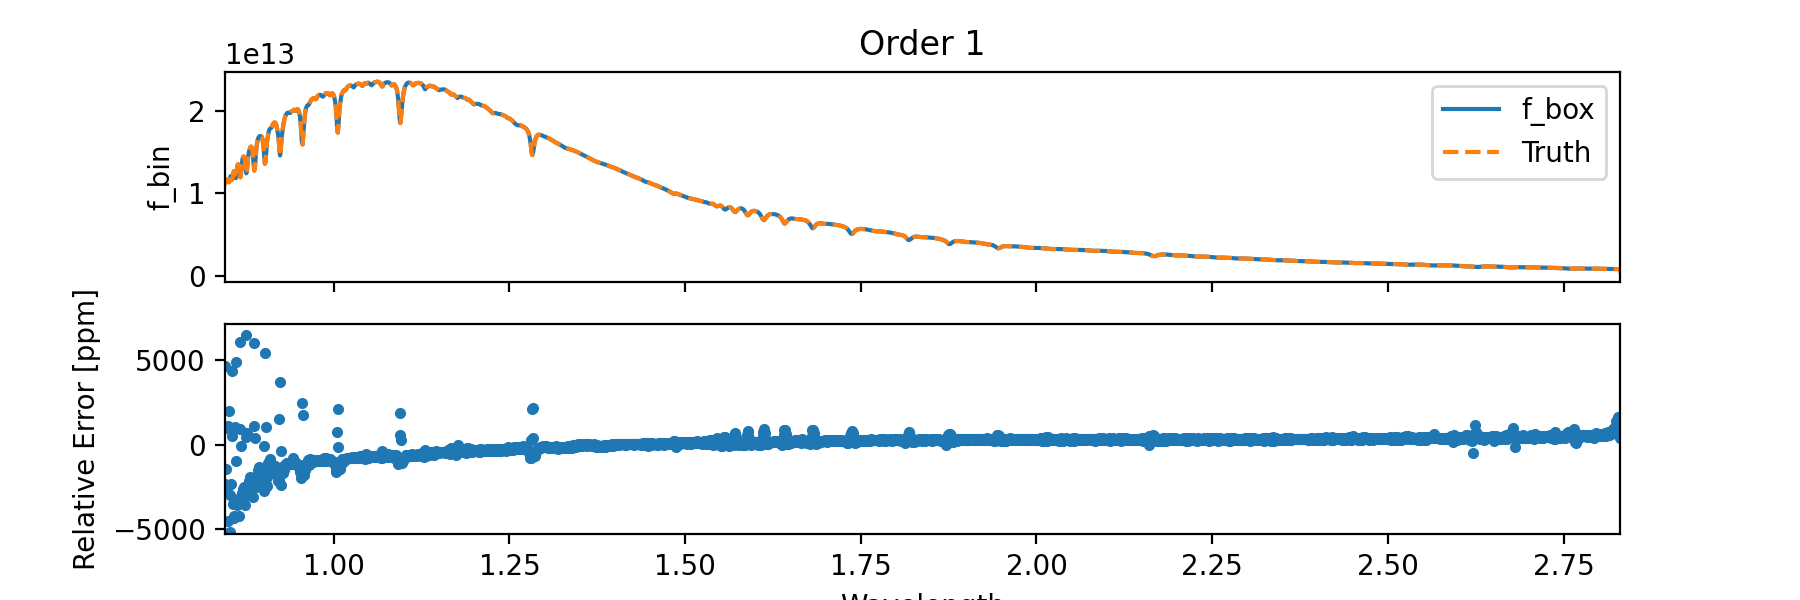

(<Figure size 900x300 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7facab48e5d0>,
       dtype=object))

In [22]:
test_2.plot_error(f_truth=test_1.f_box, to_compare='f_box')

## Oversampled

100
(39962,) (39962,)


<IPython.core.display.Javascript object>


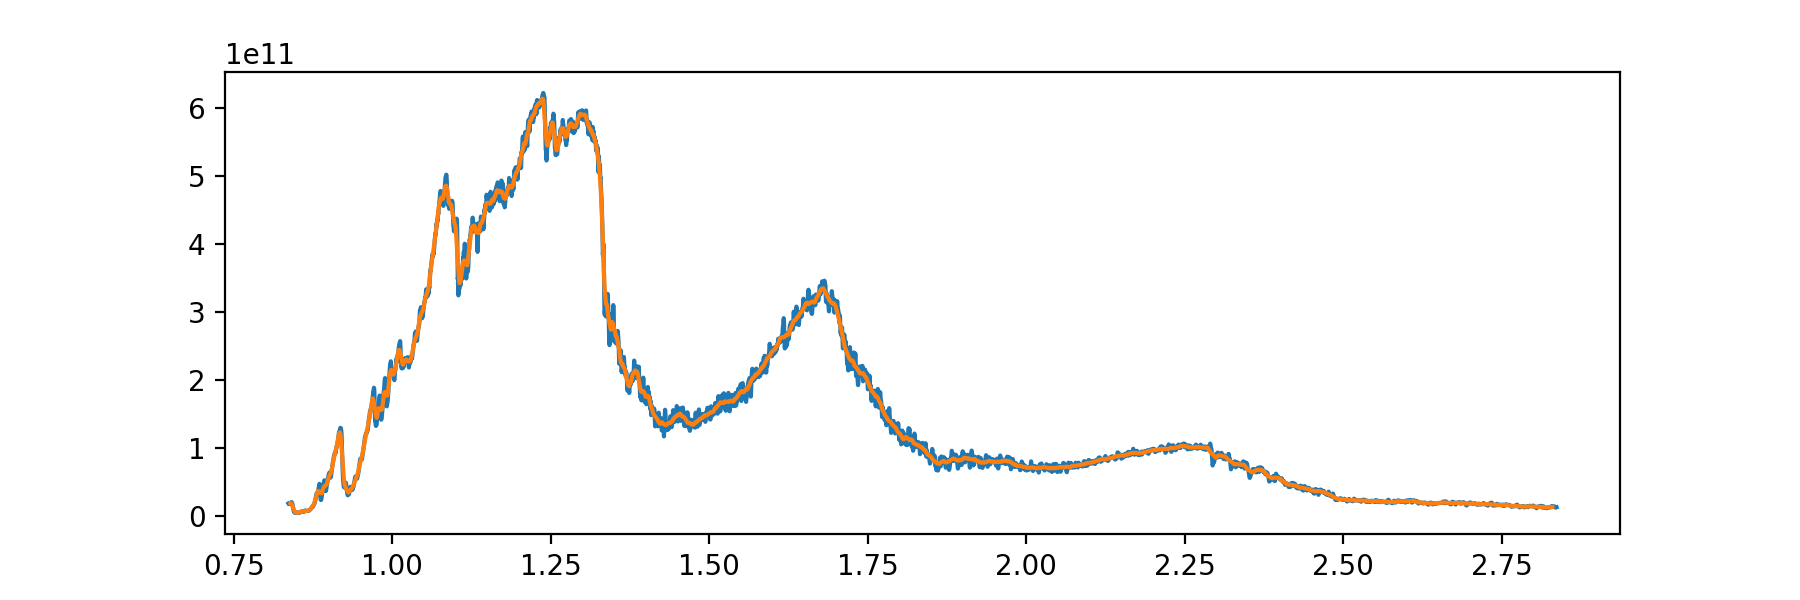

In [143]:
# blurred estimate
box_len = 201
print(box_len//2)
flux_estimate = np.convolve(simu["f_c1"]*ThroughputSOSS(1)(simu["grid_c1"]),
                            np.ones(box_len)/box_len, mode='valid')
idx_valid = slice(box_len//2,-1* box_len//2+1)
print(flux_estimate.shape, simu["grid_c1"][idx_valid].shape)

estimate = interp1d(simu["grid_c1"][idx_valid], flux_estimate, kind="linear", 
                    bounds_error=False, fill_value='extrapolate')

plt.plot(simu["grid_c1"], simu["f_c1"]*ThroughputSOSS(1)(simu["grid_c1"]))
plt.plot(simu["grid_c1"][idx_valid], flux_estimate)


<IPython.core.display.Javascript object>


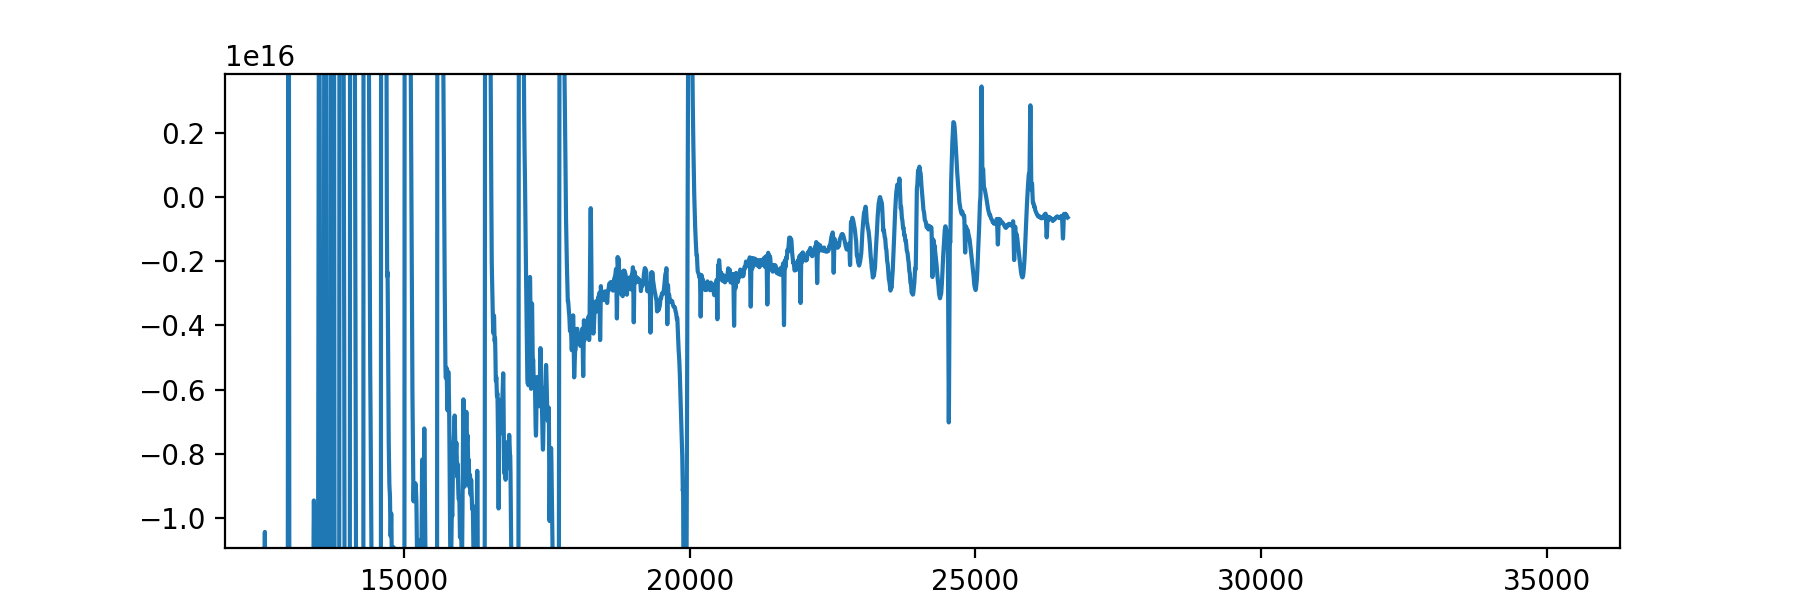

In [149]:
plt.plot(finite_first_d(simu["grid_c1"]).dot(simu["f_c1"]*ThroughputSOSS(1)(simu["grid_c1"])))

In [144]:
def get_tikho_matrix(grid, mode=None):
    
    if mode == 'zeroth':
        t_mat = finite_zeroth_d(grid)
    elif mode == 'first_d-wave':
         t_mat = finite_first_d(grid)
    elif mode == 'first_no-d-wave':
        t_mat = finite_first_d(np.arange(len(grid)))
    elif mode == 'second_d-wave':
        t_mat = finite_second_d(grid)
    elif mode == 'second_no-d-wave':
        t_mat = finite_second_d(np.arange(len(grid)))
    elif mode == 'quad_smooth_d-wave':
        t_mat = quadratic_smooth(grid)
    elif mode == 'quad_smooth_no-d-wave':
        t_mat = quadratic_smooth(np.arange(len(grid)))
    elif mode == 'lin_smooth_d-wave':
        t_mat = linear_smooth(grid)
    else:
        raise ValueError('Mode not valid')
    
# #     # Weights according to 'Thompson1989'
# #     tikho_factor_scale = np.power(estimate(grid), -1)
# #     tikho_factor_scale /= np.sum(tikho_factor_scale)
    
#     # Weights according to 'kunasz1973'
#     tikho_factor_scale = np.power(estimate(grid), -2)
#     tikho_factor_scale /= np.sum(tikho_factor_scale)
    
#     # Artificially give more weights to red border
#     tikho_factor_scale[-4:] /= 100
# #     tikho_factor_scale[:4] /= 1000

#     if 'first' in mode:
#         t_mat = diags(tikho_factor_scale[:-1]).dot(t_mat)
#     elif ('second' in mode):
#         t_mat = diags(tikho_factor_scale[1:-1]).dot(t_mat)
#     else:
#         t_mat = diags(tikho_factor_scale).dot(t_mat)
        
    
    return t_mat


In [161]:
test_extract_os = TestExtractFirstOrd(wv_1, P1, simu=simu, n_os=5, name='9000K_os=5_tilted')

<IPython.core.display.Javascript object>


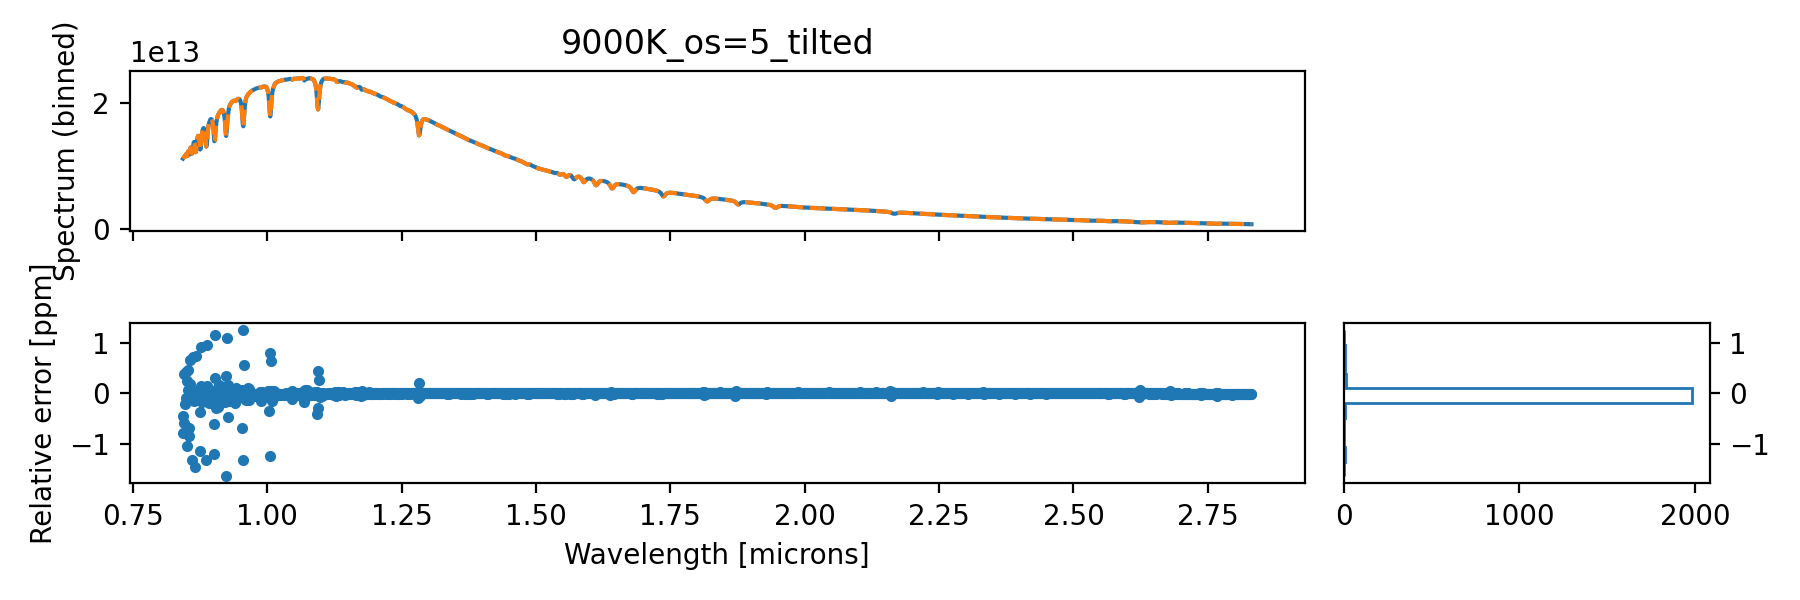

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [77]:
fig, ax = test_extract_os.compare_binned()
plt.tight_layout()
# fig.savefig('9000K_os=5_tilted.png')

Testing factors...
20/20


<IPython.core.display.Javascript object>


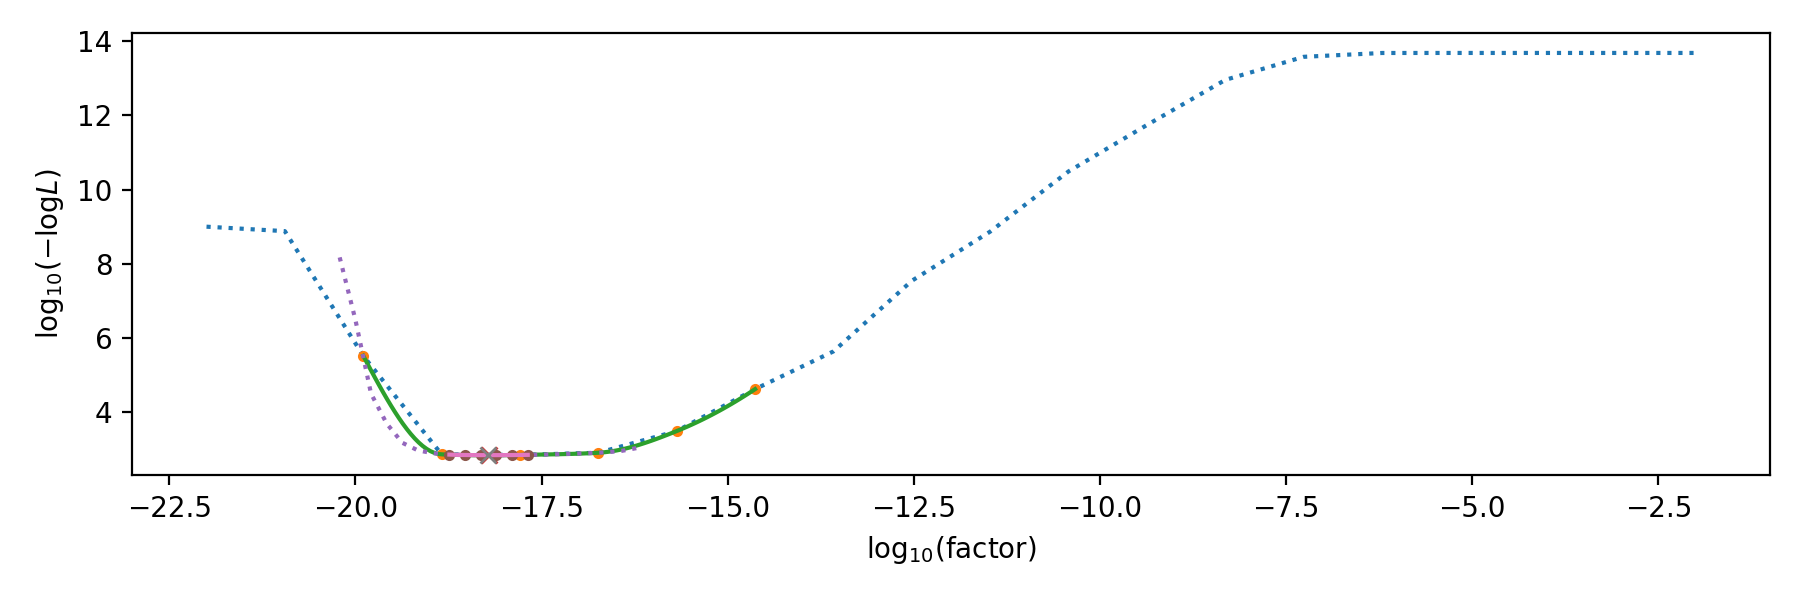

Testing factors...
20/20


In [145]:
# n_os = 5
for n_os in [5]:
    mode = 'first_d-wave'
    name = f'9000K_os={n_os}_' + mode
    if tilted:
        name += '_tilted'
    else:
        name += '_not-tilted'


    tikho_kwargs = {"t_mat":lambda x:get_tikho_matrix(x, mode=mode)}

    factors = np.logspace(-22, -2, 20)
    test_extract_os = TestExtractFirstOrd(wv_1, P1, simu=simu, n_os=n_os, name=name,# wv_range=[0.95, 2.75],
                                          factors=factors, tikho_kwargs=tikho_kwargs)
#     plt.close()
    
#     fig, ax = test_extract_os.compare_binned()
#     fig.savefig('Tikho_tests/'+name+'.png')
#     plt.close()

<IPython.core.display.Javascript object>


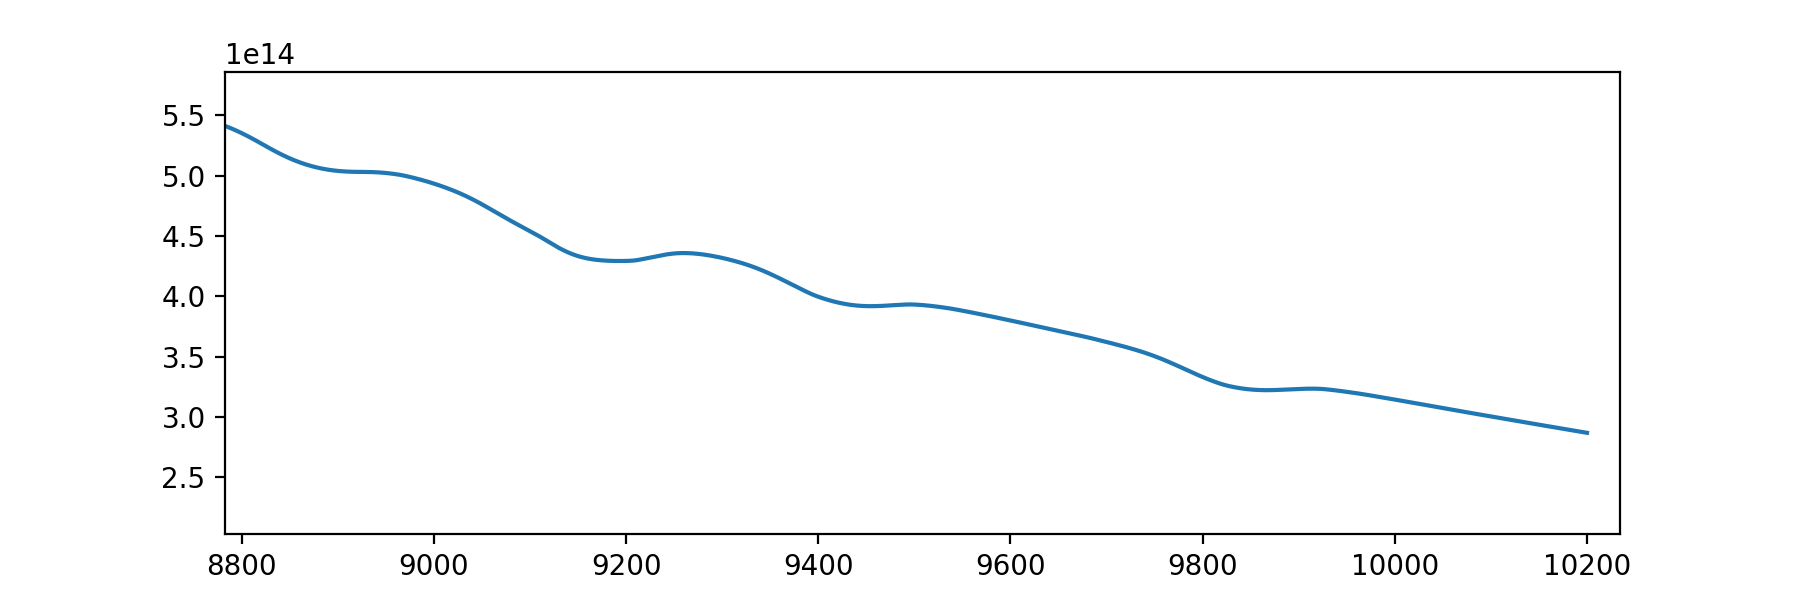

In [897]:
plt.plot(estimate(test_extract_os.grid_trpz))

<IPython.core.display.Javascript object>


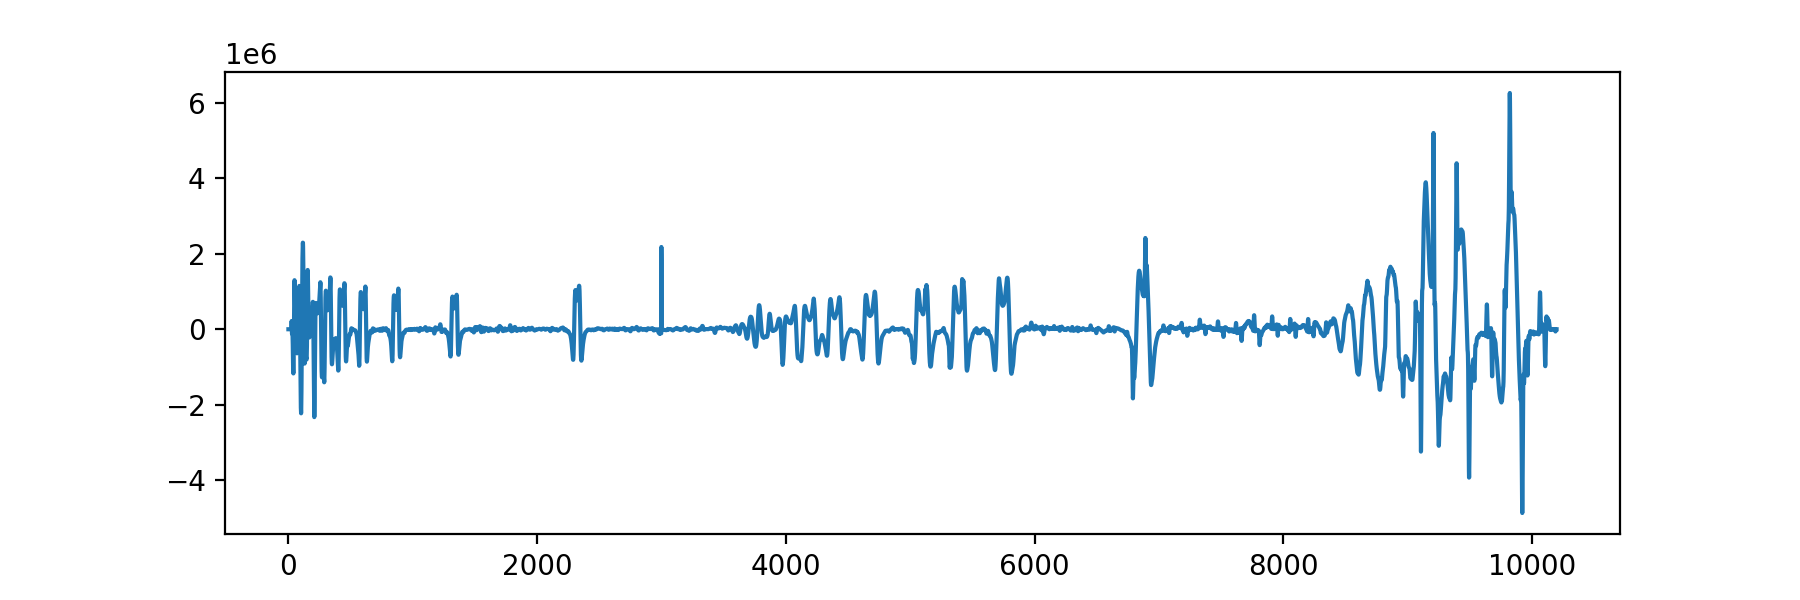

In [902]:
plt.plot(get_tikho_matrix(test_extract_os.grid_trpz, mode='second_no-d-wave').dot(estimate(test_extract_os.grid_trpz)))

<IPython.core.display.Javascript object>


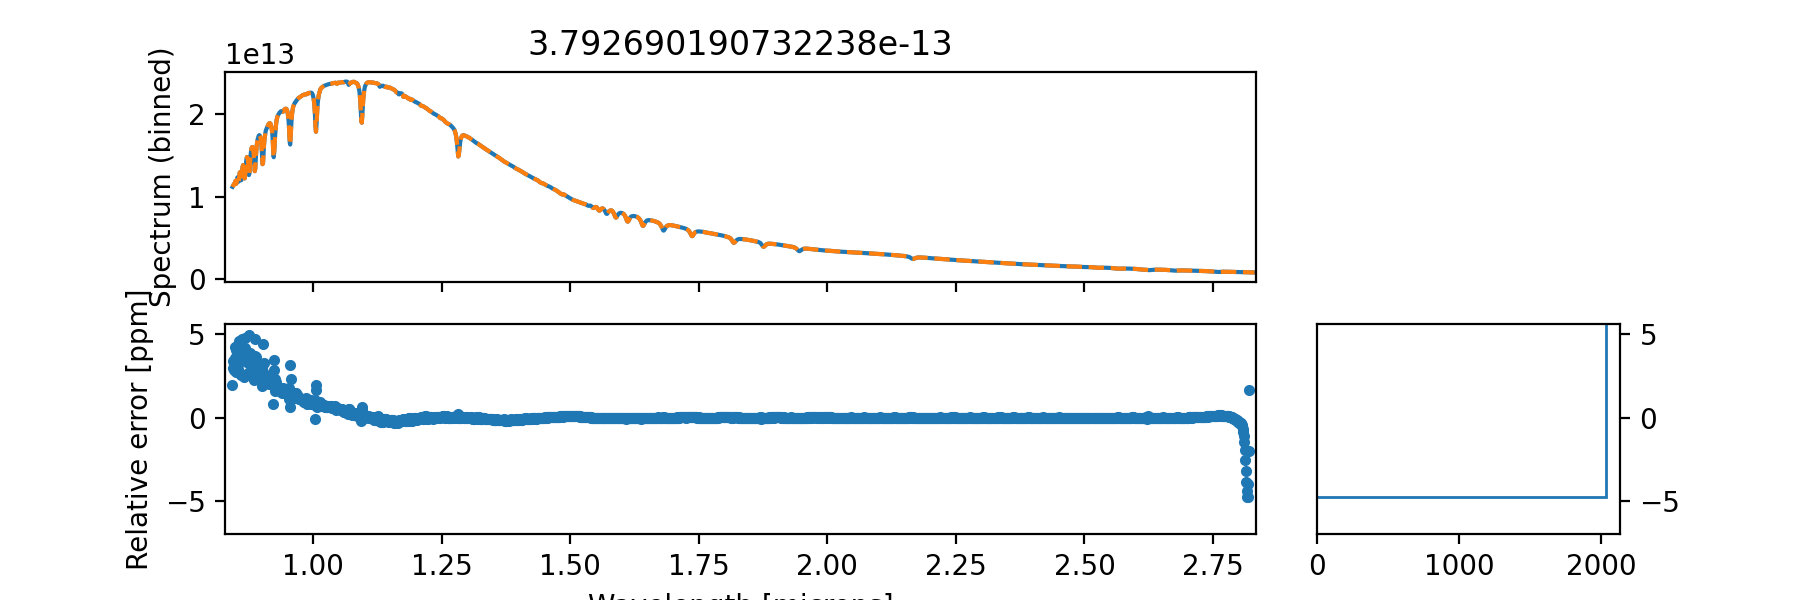

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


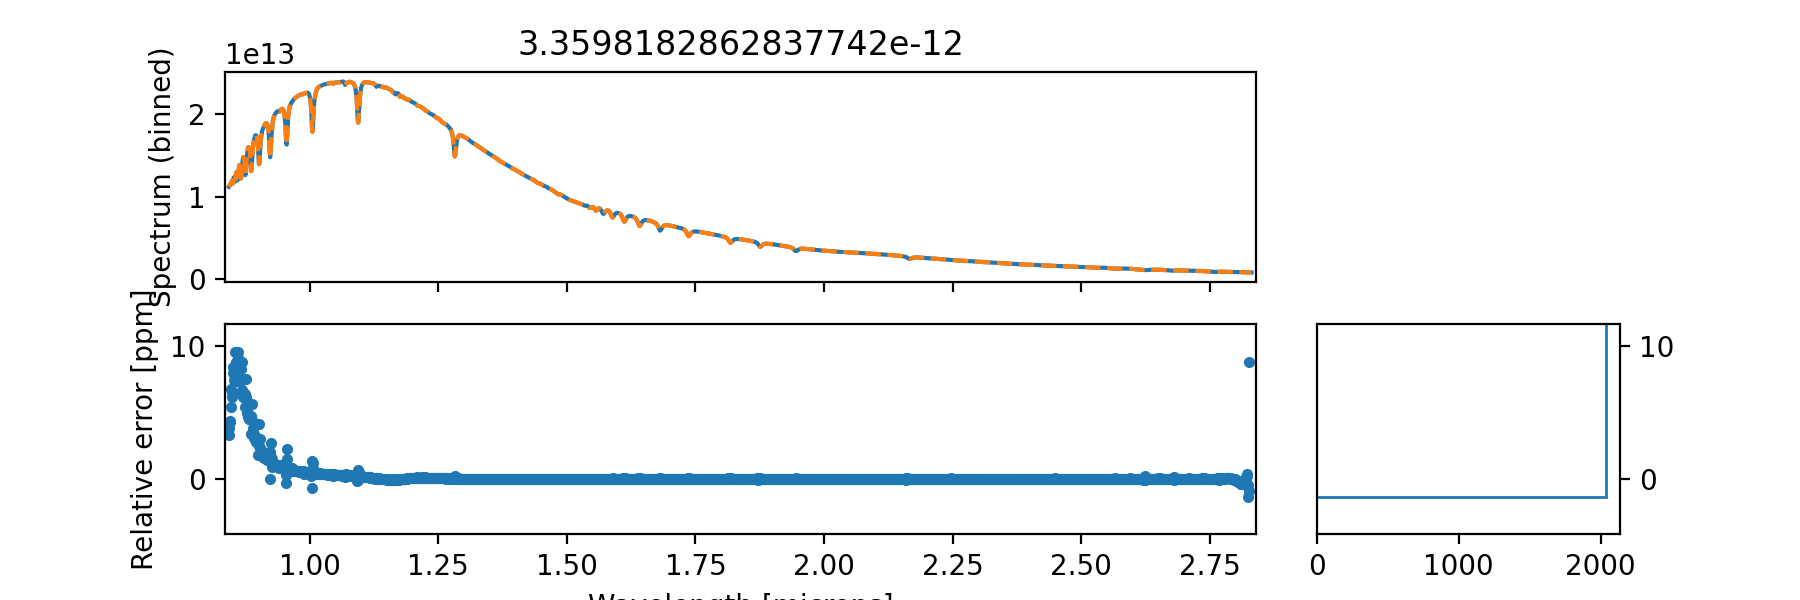

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<IPython.core.display.Javascript object>


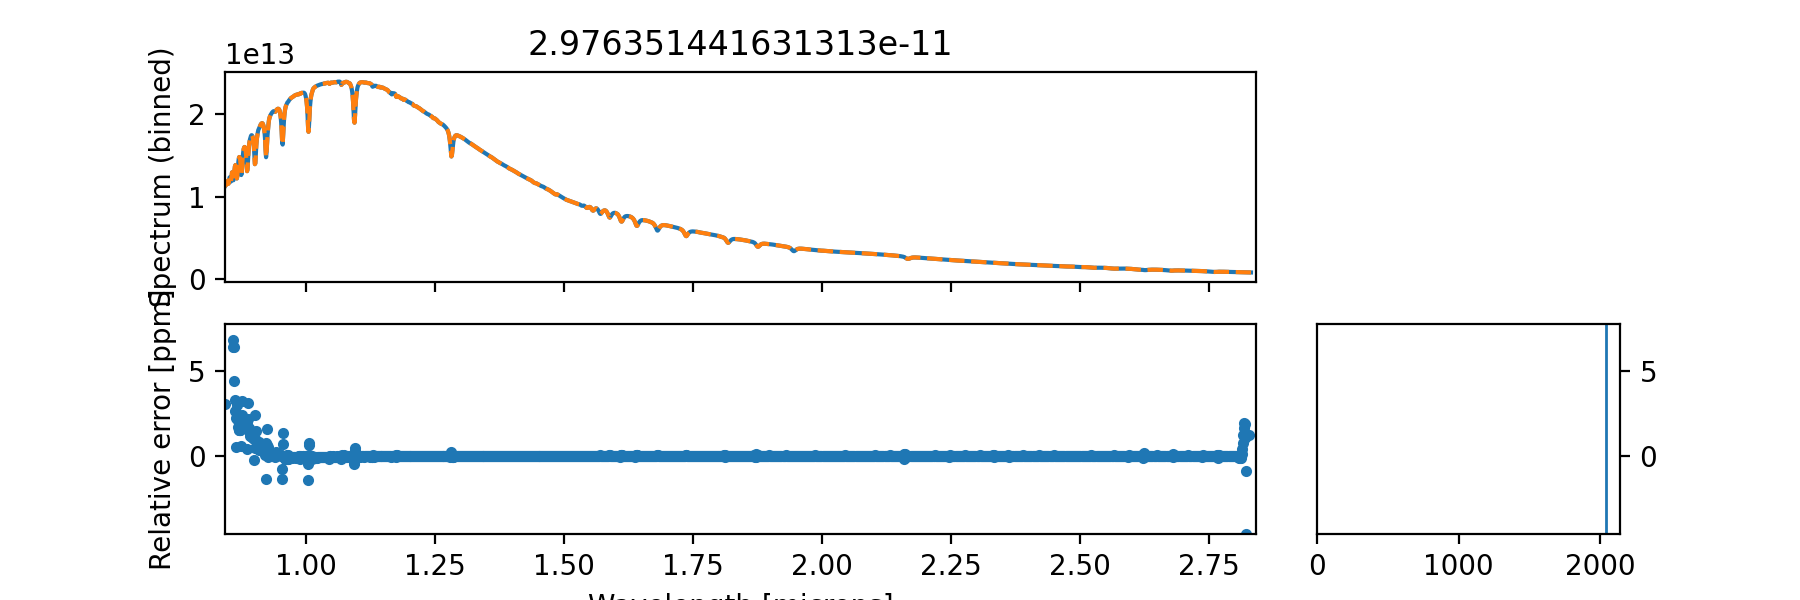

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [110]:
for i_sln, fac in enumerate(test_extract_os.tikho_tests_binned['factors']):
    if (fac > 1e-13) & (fac < 1e-10):
        fig, ax = test_extract_os.compare_binned(f_bin=test_extract_os.tikho_tests_binned['f_bin'][i_sln])#, wv_range=[0.7, 2.5])
        ax[0].set_title(fac)

<IPython.core.display.Javascript object>


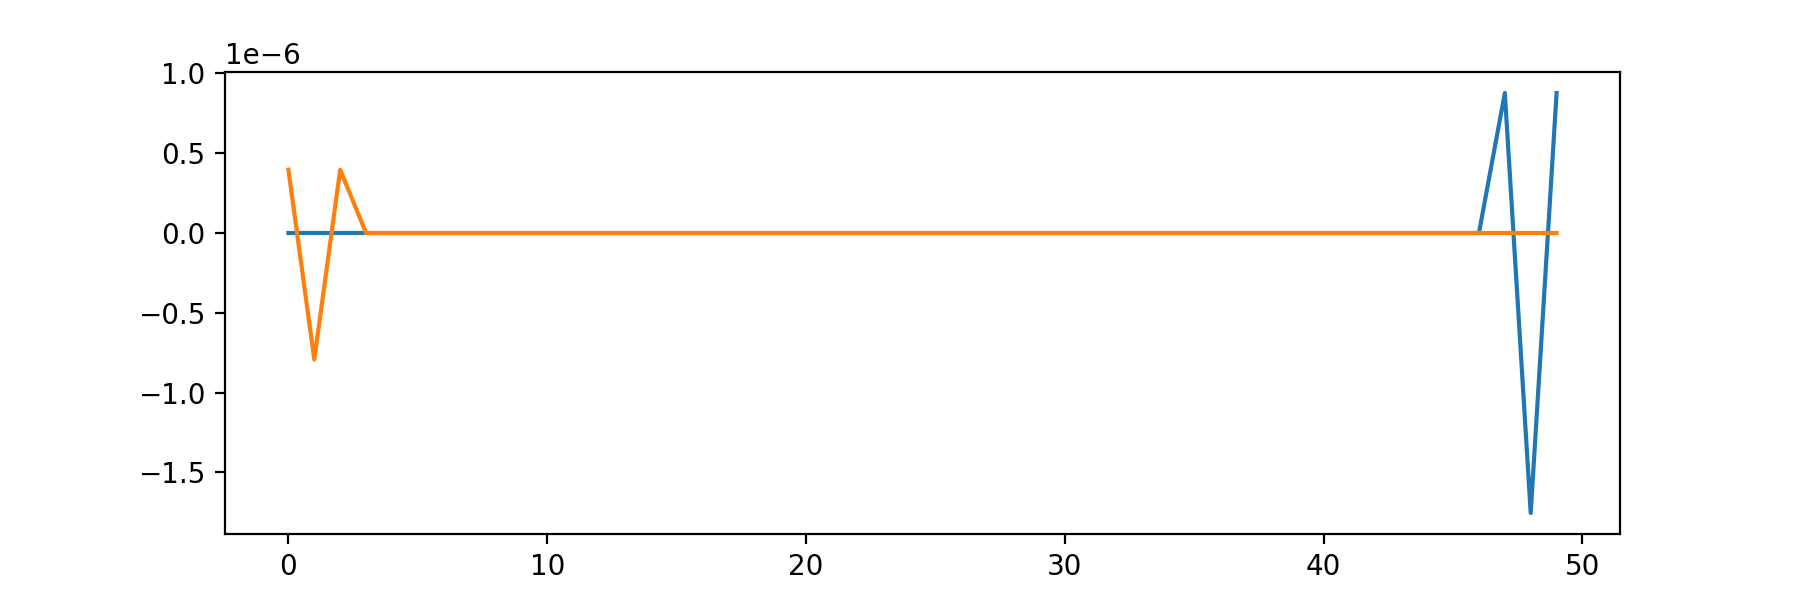

In [824]:
tikho_mat = get_tikho_matrix(test_extract_os.grid_trpz, mode='second_no-d-wave')
plt.plot(tikho_mat[-1, -50:].toarray().squeeze())
plt.plot(tikho_mat[0, :50].toarray().squeeze())

<IPython.core.display.Javascript object>


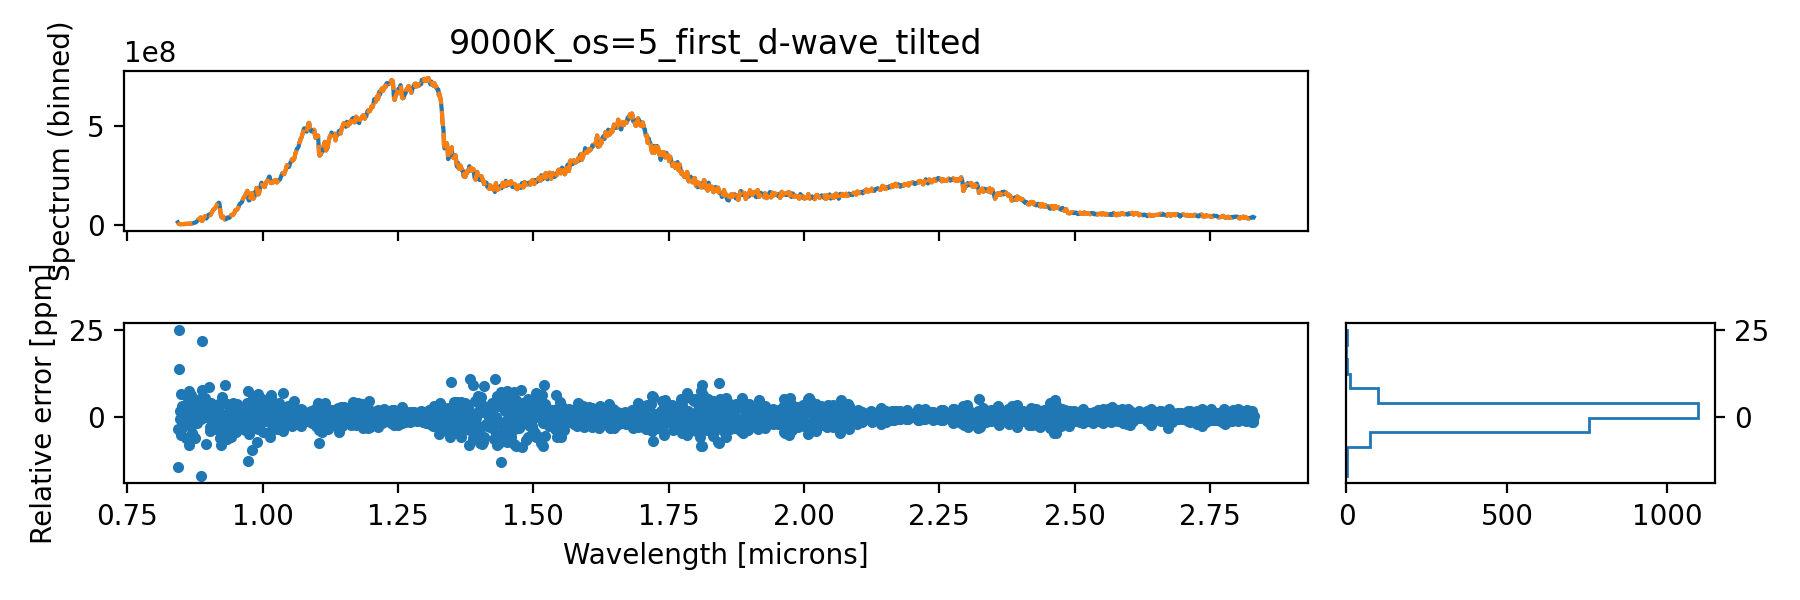

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [146]:
fig, ax = test_extract_os.compare_binned()#wv_range=[0.95, 2.75])
plt.tight_layout()
# fig.savefig('Tikho_tests/'+name+'.png')
# fig.savefig('Tikho_tests/'+name+'_narrow_boundaries.png')
# fig.savefig('Tikho_tests/'+name+'_zoom.png')
# fig.savefig('Tikho_tests/'+name+'_weight_red_bound.png')

In [734]:
from extract.regularisation import get_nyquist_matrix
# from extract.convolution import NyquistKer, get_c_matrix
from scipy.sparse import diags

In [735]:
#     def get_nyquist_matrix(grid, integrate=False, n_sampling=2,
#                            thresh=1e-5, **kwargs):
#         """
#         Get the tikhonov regularisation matrix based on
#         a Nyquist convolution matrix (convolution with
#         a kernel with a resolution given by the sampling
#         of a grid). The Tikhonov matrix will be given by
#         the difference of the nominal solution and
#         the convolved solution.

#         Parameters
#         ----------
#         grid: 1d-array
#         Grid to project the kernel
#     integrate: bool, optional
#         If True, add integration weights to the tikhonov matrix, so
#         when the squared norm is computed, the result is equivalent
#         to the integral of the integrand squared.
#     n_sampling: int, optional
#         sampling of the grid. Default is 2, so we assume that
#         the grid is Nyquist sampled.
#     thresh: float, optional
#         Used to define the maximum length of the kernel.
#         Truncate when `kernel` < `thresh`
#     kwargs:
#         `interp1d` kwargs used to get FWHM as a function of the grid.
#     """

#     # Get nyquist kernel function
#     ker = NyquistKer(grid, n_sampling=n_sampling, **kwargs)

#     # Build convolution matrix
#     conv_matrix = get_c_matrix(ker, grid, thresh=thresh)

#     # Build tikhonov matrix
#     t_mat = conv_matrix

#     if integrate:
#         # The grid may not be evenly spaced, so
#         # add an integration weight
#         d_grid = np.diff(grid)
#         d_grid = np.concatenate([d_grid, [d_grid[-1]]])
#         t_mat = diags(np.sqrt(d_grid)).dot(t_mat)

#     return t_mat

def get_tikho_matrix(grid, **kwargs):
    
    t_mat = get_nyquist_matrix(grid, **kwargs)
    
    # Weights according to 'kunasz1973'
    tikho_factor_scale = np.power(estimate(grid), -2)
    tikho_factor_scale /= np.sum(tikho_factor_scale)

#     t_mat = diags(tikho_factor_scale[:-1]).dot(t_mat)
#     t_mat = diags(tikho_factor_scale[1:-1]).dot(t_mat)
    t_mat = diags(tikho_factor_scale).dot(t_mat)
    return t_mat

In [790]:
n_os = 5
name = 'nyquist'
tikho_kwargs = {"t_mat":lambda x:get_tikho_matrix(x, integrate=True)}

factors = np.logspace(-18, -4, 20)
test_extract_os = TestExtractFirstOrd(wv_1, P1, simu=simu, n_os=n_os, name=name,
                                      factors=factors, tikho_kwargs=tikho_kwargs, wv_range=[0.7, 2.8], thresh=1e-5)

Testing factors...
20/20
Testing factors...
20/20


<IPython.core.display.Javascript object>


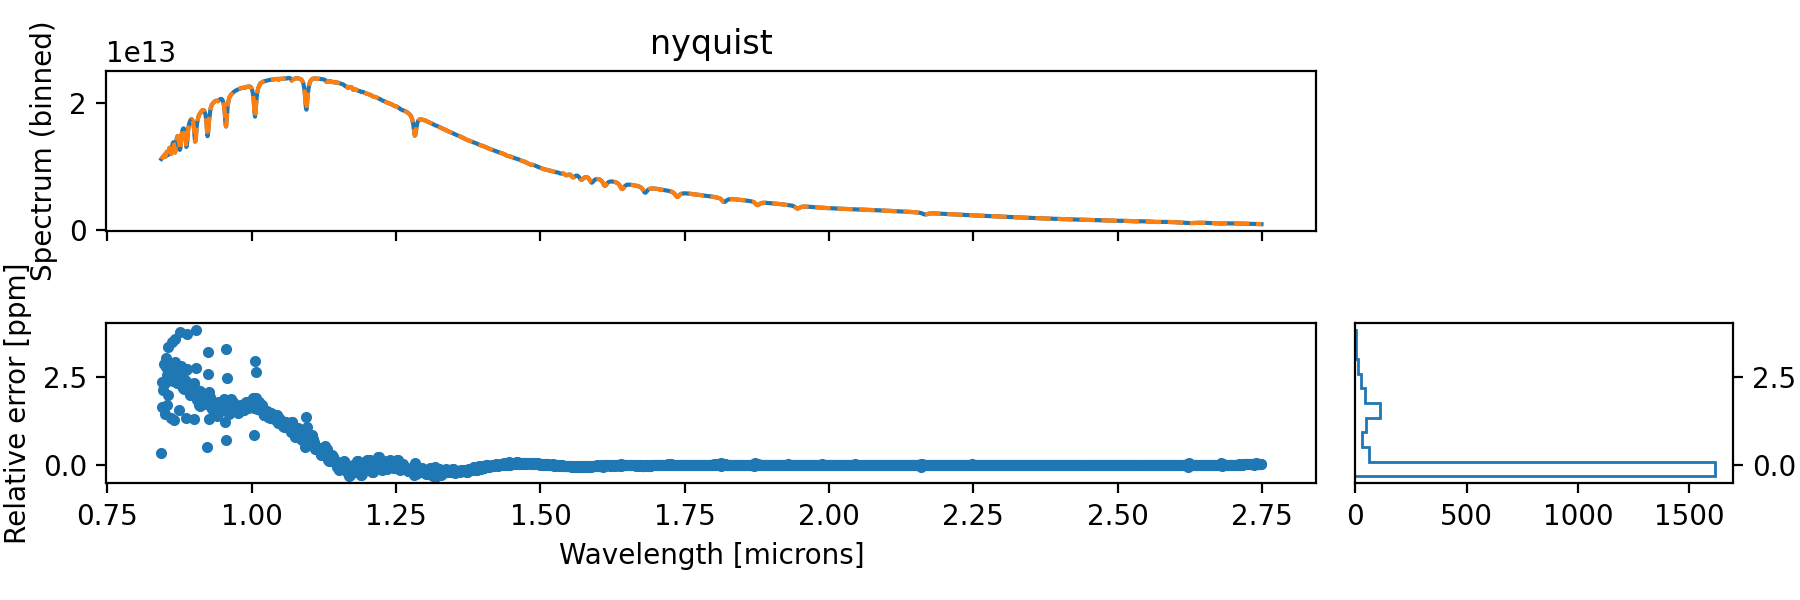

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [791]:
fig, ax = test_extract_os.compare_binned(wv_range=[0.7, 2.75])
plt.tight_layout()

<IPython.core.display.Javascript object>


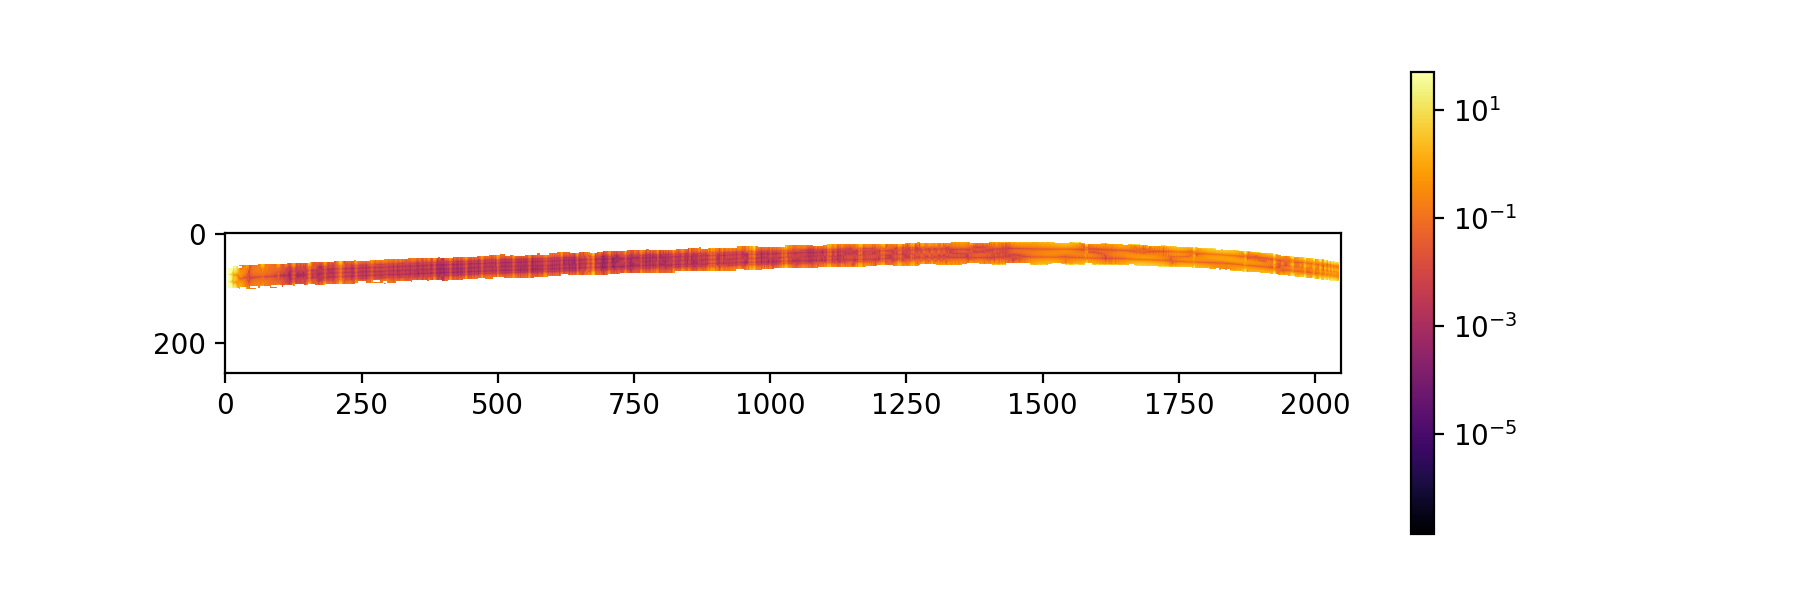

In [765]:
plt.imshow(np.abs(test_extract_os.scidata - test_extract_os.rebuilt)/test_extract_os.scidata*1e6, vmax=50, norm=LogNorm())
plt.colorbar()

<IPython.core.display.Javascript object>


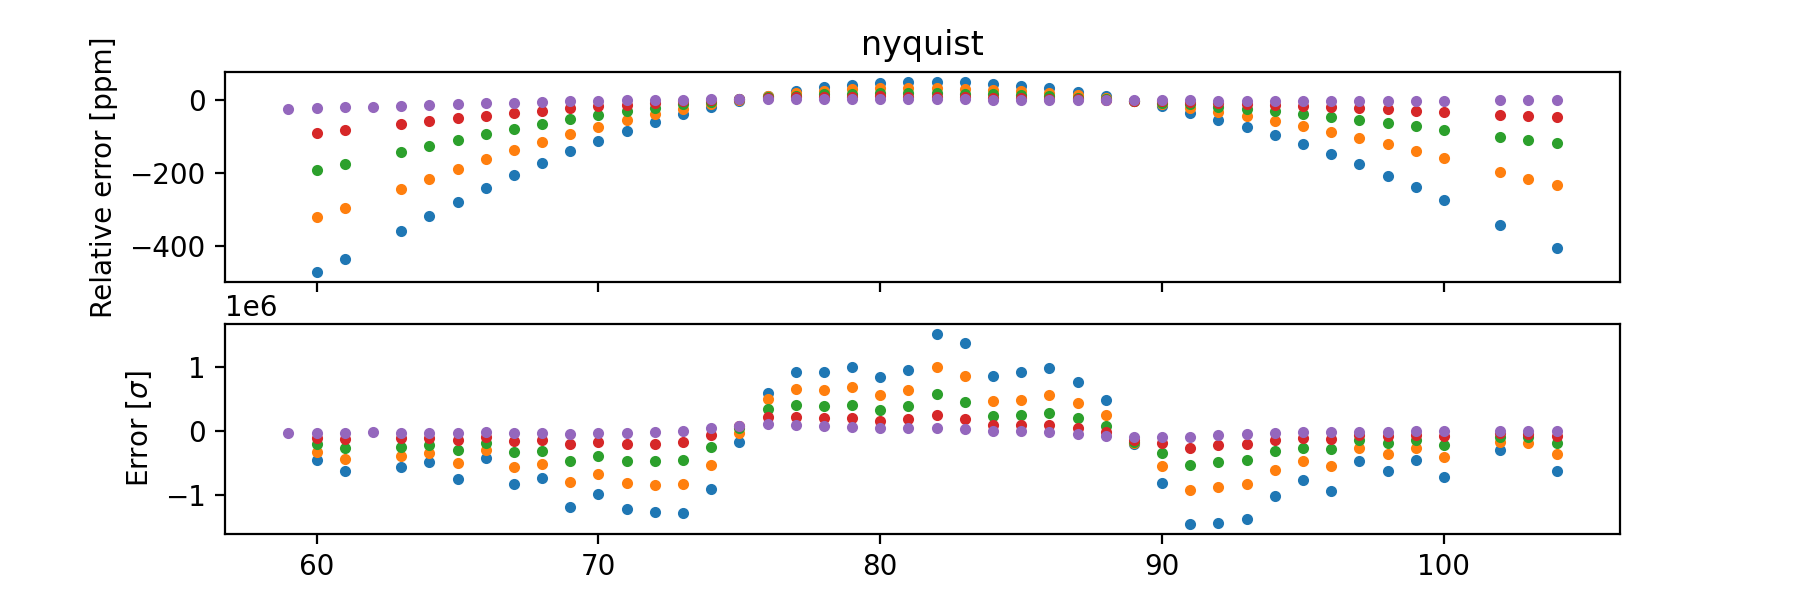

In [767]:
fig, ax = test_extract_os.show_col_residuals(cols=np.arange(10,15))
# ax[1].twinx().plot(np.arange(50,150), P1[50:150,10])

In [121]:
# scidata = simu["data"]
# # uncert = np.clip(np.sqrt(scidata), 1, None)
# uncert = scidata * 0 + 1

# wave_grid = test_1.wave_grid
# wv_cols = test_1.wv_cols
# bin_limits = test_1.bin_limits

# grid_os = oversample_grid(test_1.grid_trpz, 5)


# extra_trpz = TrpzOverlap([P1], [wv_1], [fct_ones], [np.array([0,1,0])],
#                          lam_grid=grid_os, orders=[1])
# # extra_trpz = TrpzBox(P1, wv_1, lam_grid=grid_os, box_width=30)
# f_k = extra_trpz.extract(data=scidata, sig=uncert)
# bin_center, f_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=f_k)

# idx = (simu['grid_c1'] >= extra_trpz.lam_grid.min())  &  (simu['grid_c1'] <= extra_trpz.lam_grid.max())
# _, f_bin_th = extra_trpz.bin_to_pixel(grid_pix=bin_limits,
#                                       f_k_c=(simu['f_c1']*ThroughputSOSS(1)(simu['grid_c1']))[idx],
#                                       grid_f_k=simu['grid_c1'][idx])

In [221]:
test_extract_os = TestExtractFirstOrd(wv_1, P1, simu=simu, n_os=5)

<IPython.core.display.Javascript object>


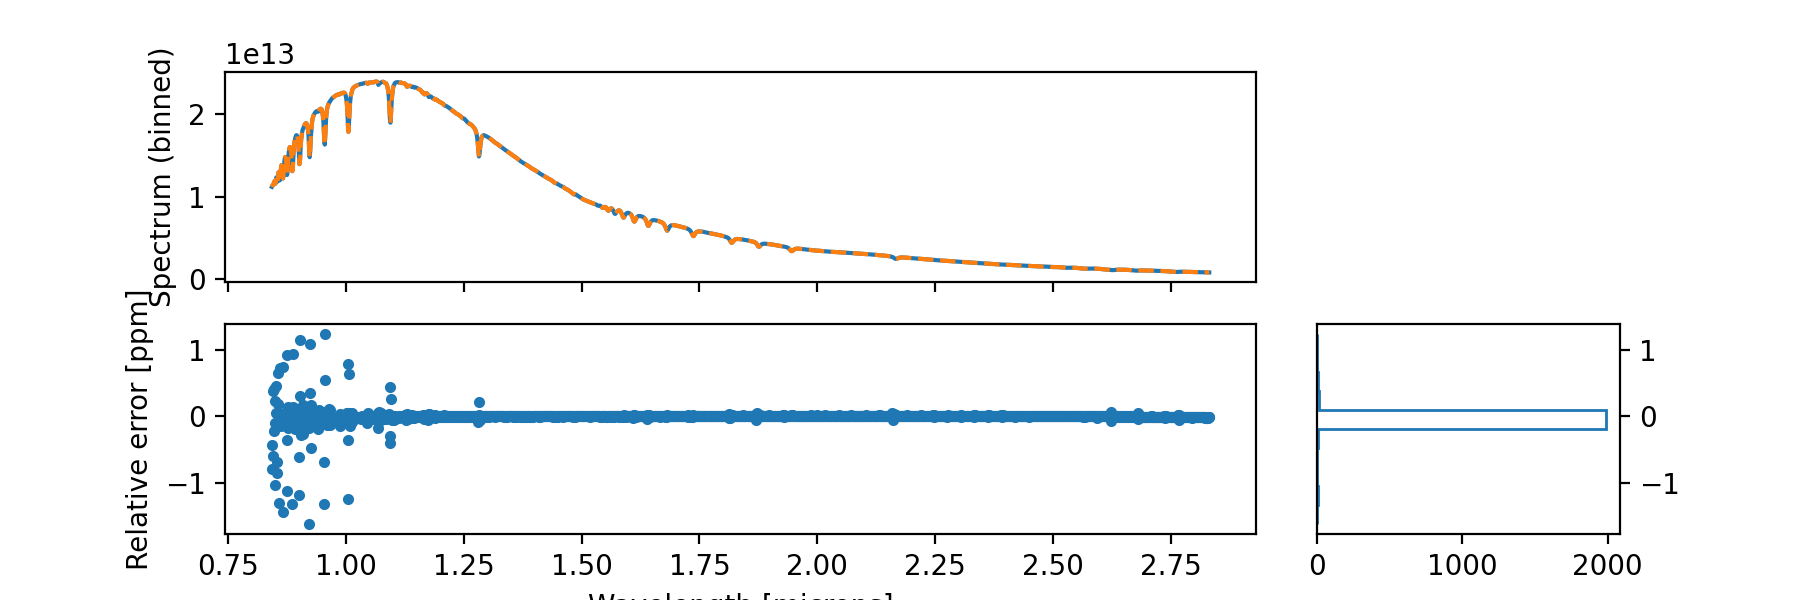

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(<Figure size 900x300 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fac5ff75450>])

In [216]:
test_extract_os.compare_binned()

In [210]:
from simulation_utils import add_noise

In [272]:
data_noisy = add_noise(simu['data'])
uncert = np.sqrt(simu['data'] + 20**2)

test_extract_os = TestExtractFirstOrd(wv_1, P1, scidata=data_noisy, uncert=uncert, simu=simu, n_os=5)

<IPython.core.display.Javascript object>


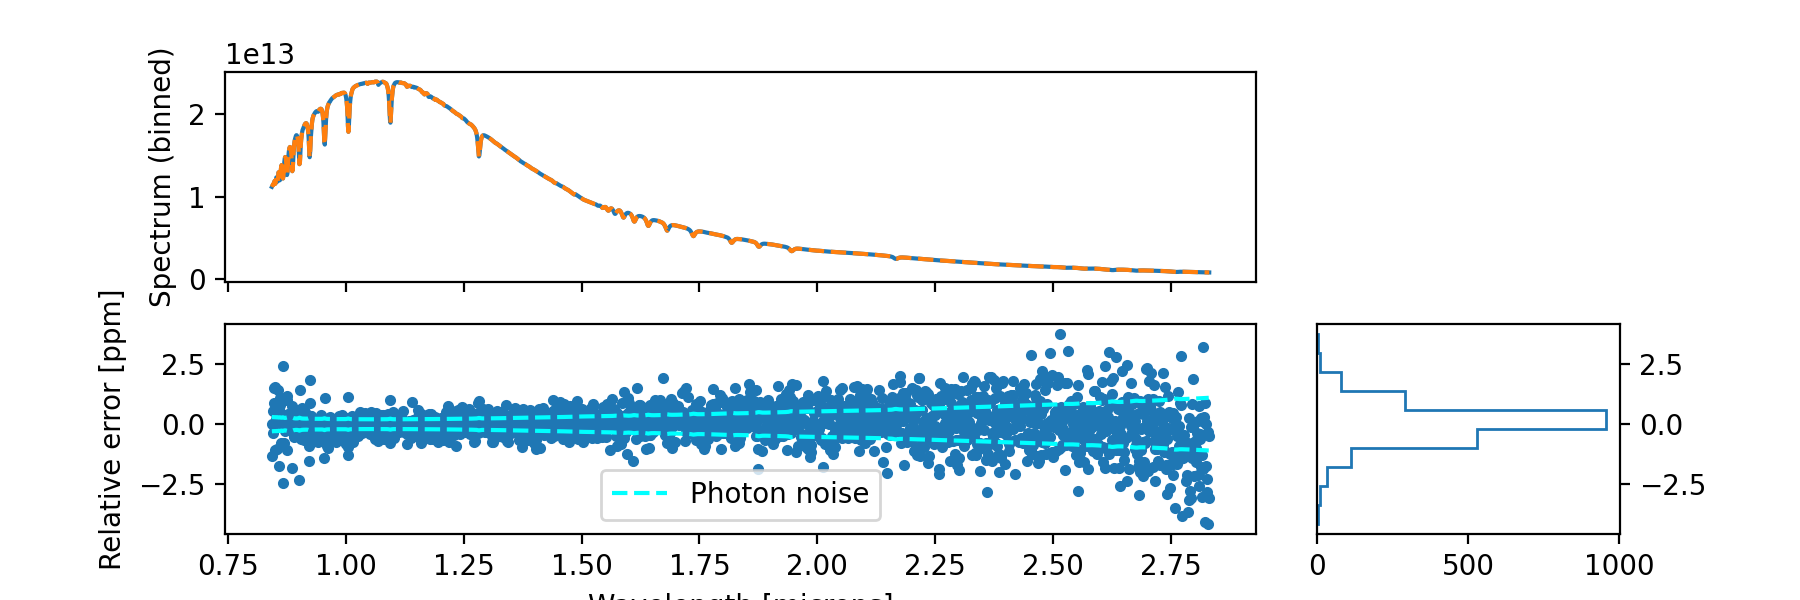

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [274]:
fig, ax = test_extract_os.compare_binned(wv_range=None)

## Tikhonov

Testing factors...
15/15


<IPython.core.display.Javascript object>


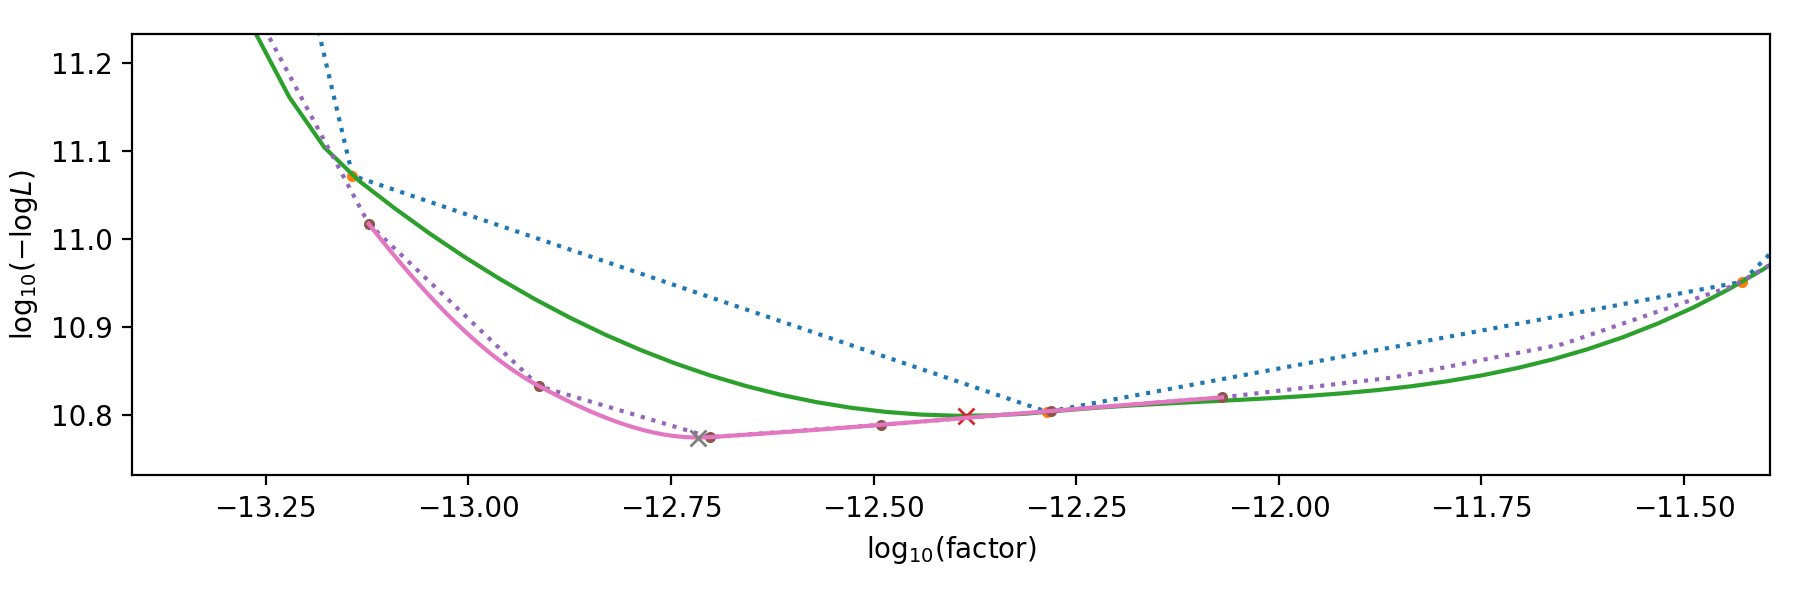

Testing factors...
20/20


In [281]:
factors = np.logspace(-20,-8,15)
test_extract_os = TestExtractFirstOrd(wv_1, P1, simu=simu, n_os=5, factors=factors, i_plot=True)

<IPython.core.display.Javascript object>


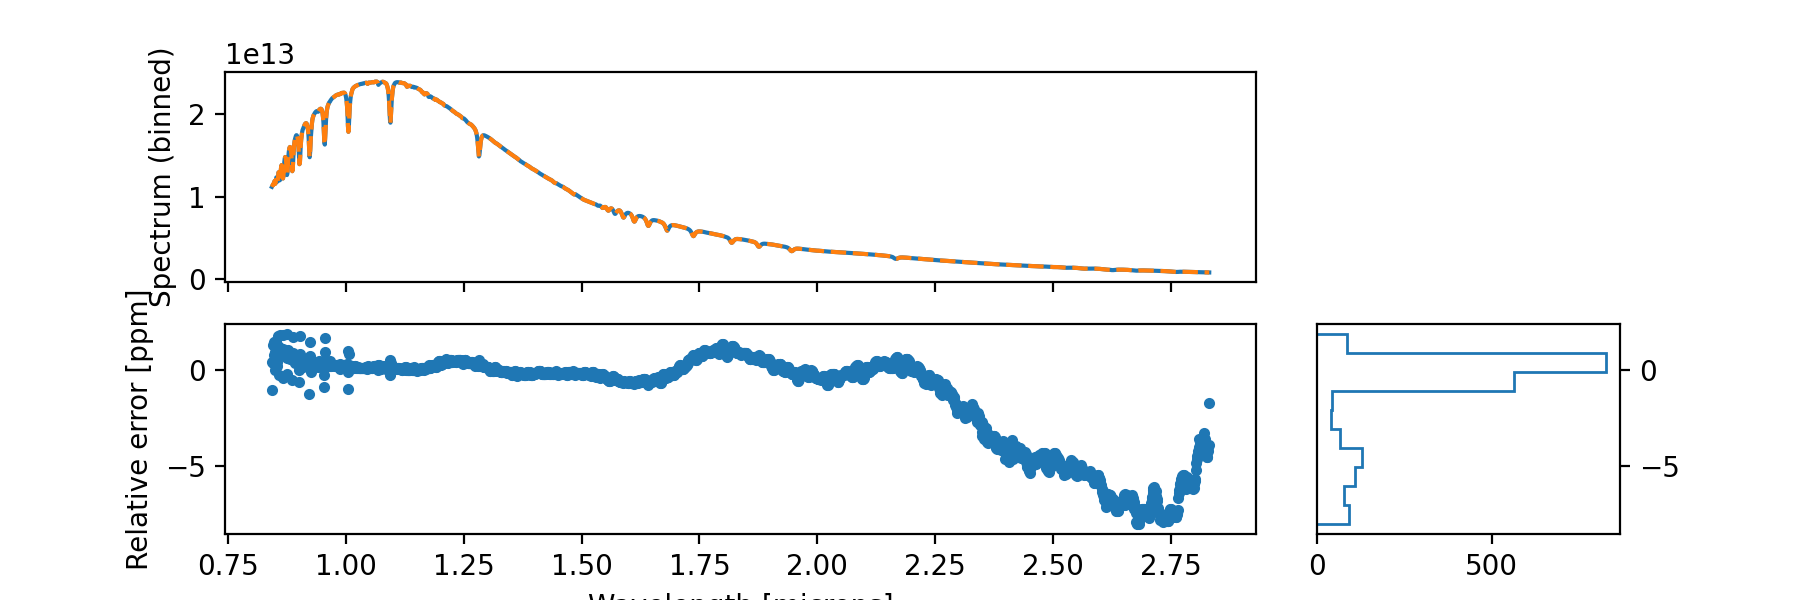

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(<Figure size 900x300 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fac2aaec610>])

In [282]:
test_extract_os.compare_binned()

### Custom tikhonov

In [403]:
from extract.regularisation import finite_second_d, finite_first_d, finite_zeroth_d

In [284]:
from scipy.sparse import diags

In [422]:
estimate = interp1d(simu["grid_c1"], simu["f_c1"]*ThroughputSOSS(1)(simu["grid_c1"]), kind="linear", 
                    bounds_error=False, fill_value='extrapolate')
# estimate = interp1d(simu["grid_c1"], simu["f_c1"], kind="linear", 
#                     bounds_error=False, fill_value='extrapolate')

In [427]:
def get_tikho_matrix(grid):
    
#     t_mat = finite_first_d(grid)
    t_mat = finite_first_d(np.arange(len(grid)))
#     t_mat = finite_second_d(grid)
#     t_mat = finite_second_d(np.arange(len(grid)))

    tikho_factor_scale = np.power(estimate(grid), -2)
    tikho_factor_scale /= np.sum(tikho_factor_scale)
#     print(t_mat.shape, tikho_factor_scale[:-1].shape)
    t_mat = diags(tikho_factor_scale[:-1]).dot(t_mat)
    return -1 * t_mat

# def get_tikho_matrix(grid):
    
#     t_mat = finite_zeroth_d(grid)
# #     t_mat = finite_first_d(grid)
# #     t_mat = finite_first_d(np.arange(len(grid)))
# #     t_mat = finite_second_d(grid)
# #     t_mat = finite_second_d(np.arange(len(grid)))

#     tikho_factor_scale = np.power(estimate(grid), -1)
#     tikho_factor_scale /= np.sum(tikho_factor_scale)
# #     print(t_mat.shape, tikho_factor_scale[:-1].shape)
#     t_mat = diags(tikho_factor_scale[:]).dot(t_mat)
#     return t_mat

In [428]:
tikho_kwargs = {"t_mat":get_tikho_matrix}

Testing factors...
20/20


<IPython.core.display.Javascript object>


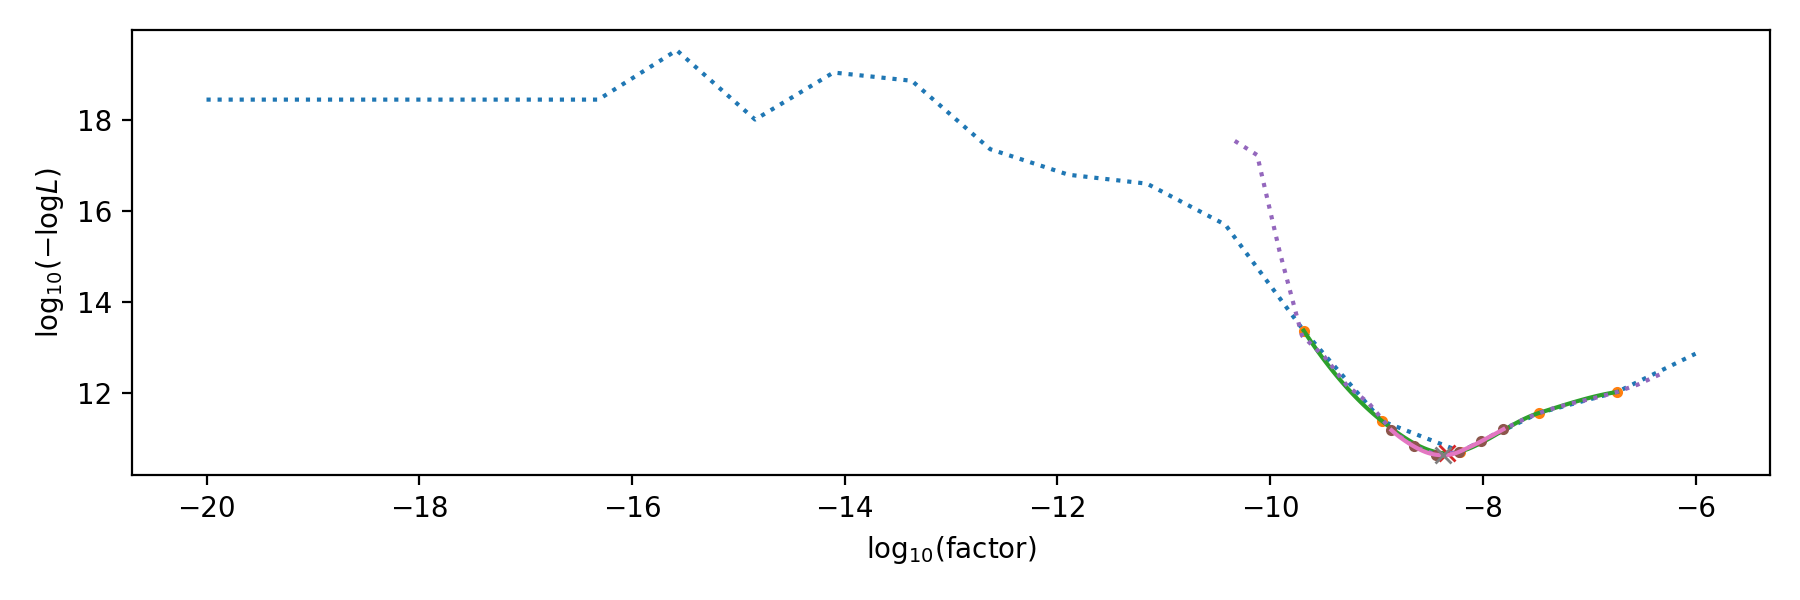

Testing factors...
20/20


In [429]:
factors = np.logspace(-20, -6, 20)
test_extract_os = TestExtractFirstOrd(wv_1, P1, simu=simu, n_os=5, factors=factors, tikho_kwargs=tikho_kwargs)

<IPython.core.display.Javascript object>


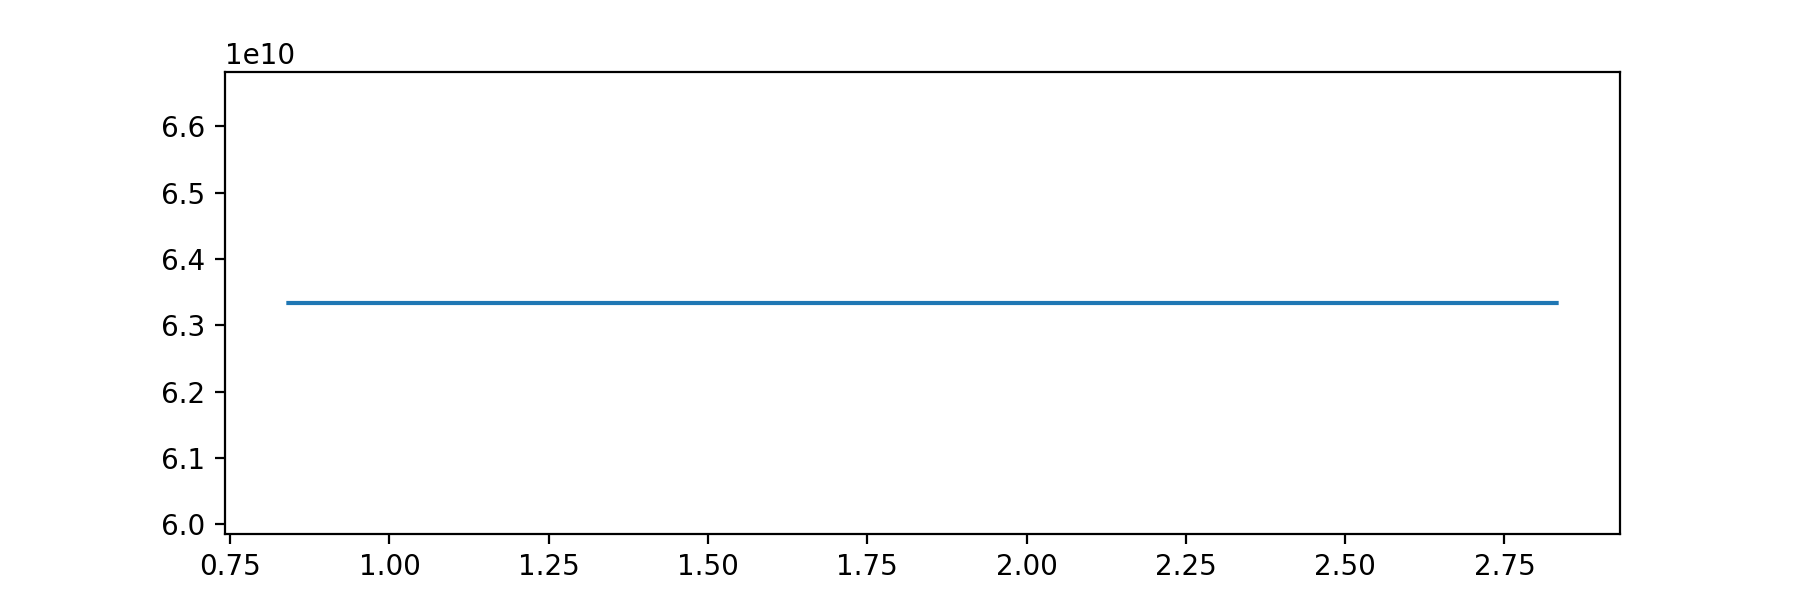

In [414]:
plt.plot(test_extract_os.simu_grid[:], get_tikho_matrix(test_extract_os.simu_grid).dot(test_extract_os.f_th))

<IPython.core.display.Javascript object>


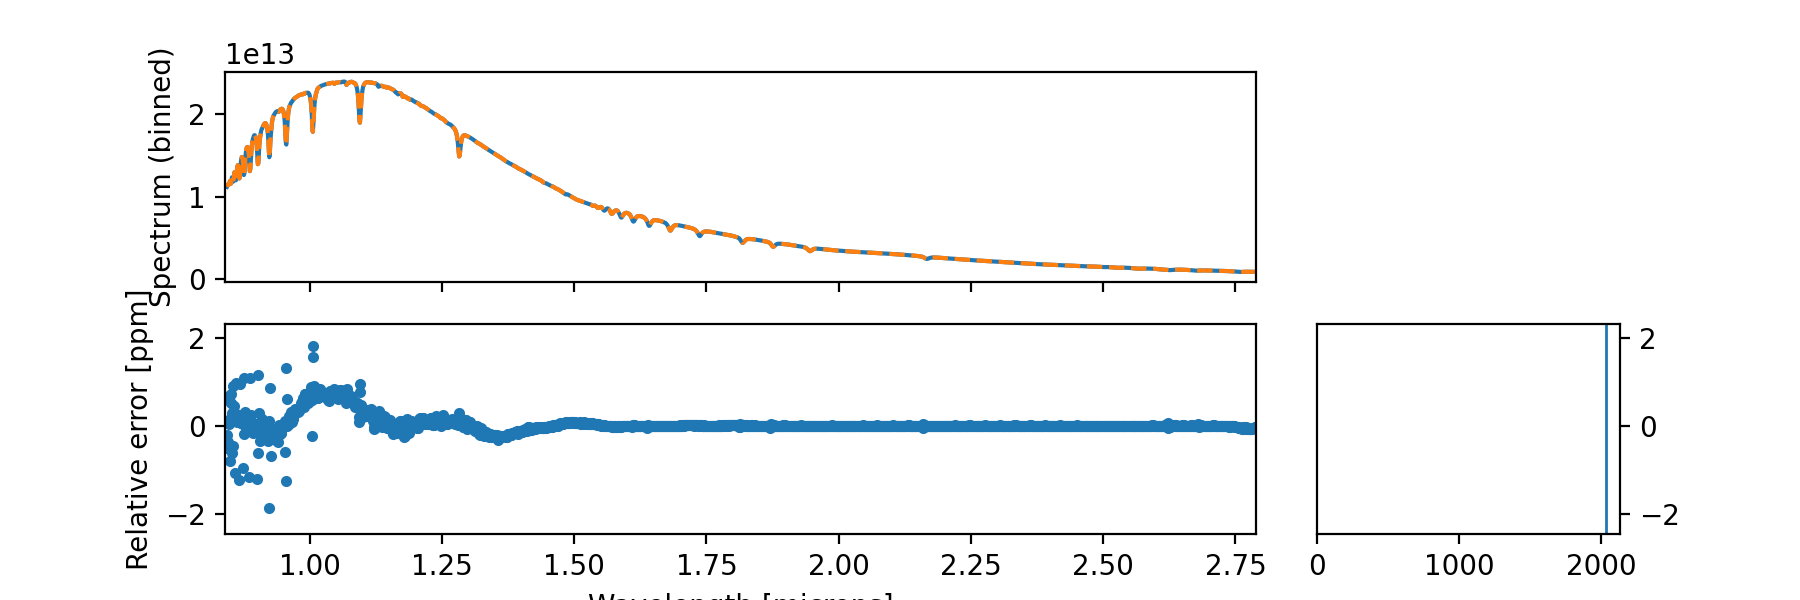

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(<Figure size 900x300 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fac1b8ad990>])

In [430]:
test_extract_os.compare_binned()

Testing factors...
20/20


<IPython.core.display.Javascript object>


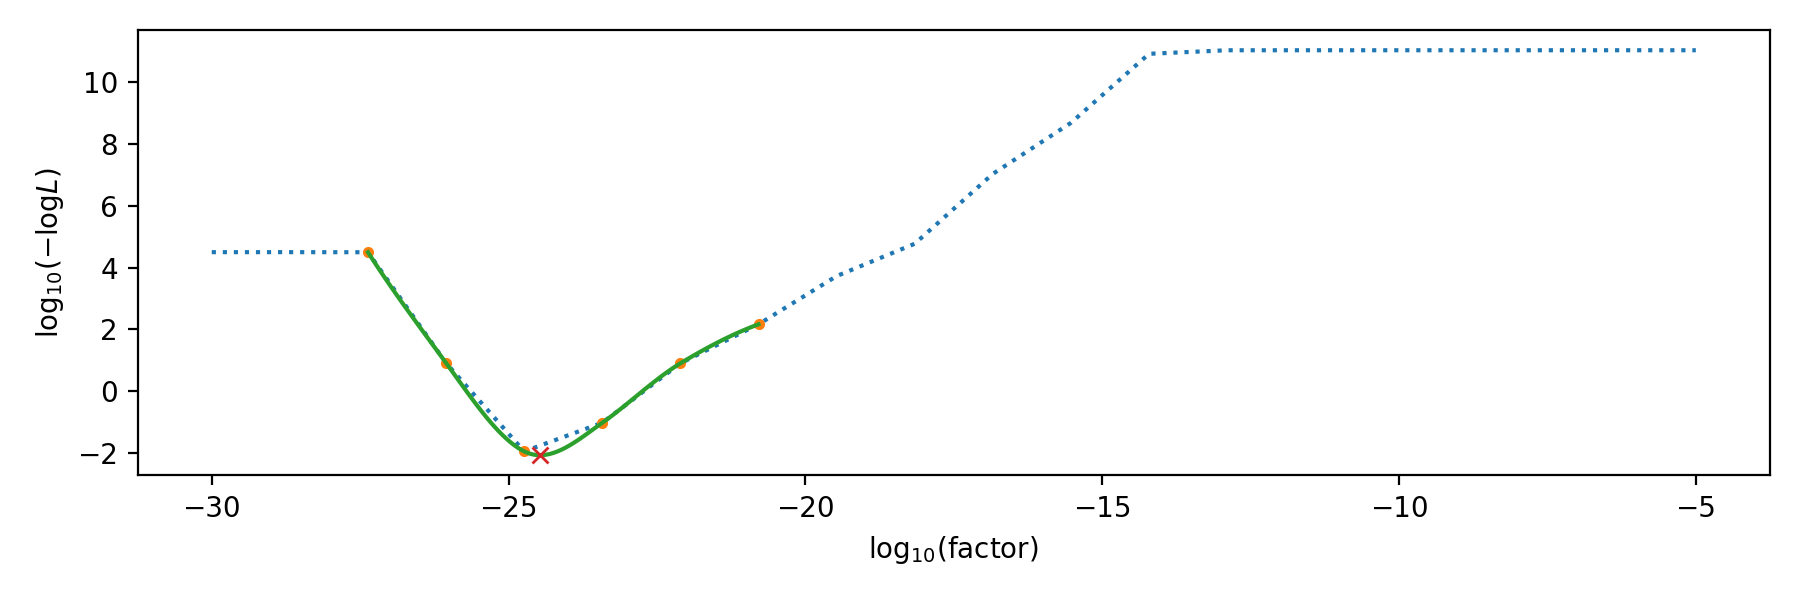

In [107]:
# Determine which factors to tests.
factors = np.logspace(-30, -5, 20)

# Tests all these factors.
tests = extra_trpz.get_tikho_tests(factors, data=scidata, sig=uncert, tikho_kwargs=tikho_kwargs)

# Find the best factor.
best_fac = extra_trpz.best_tikho_factor(tests=tests, i_plot=True)

Testing factors...
20/20


<IPython.core.display.Javascript object>


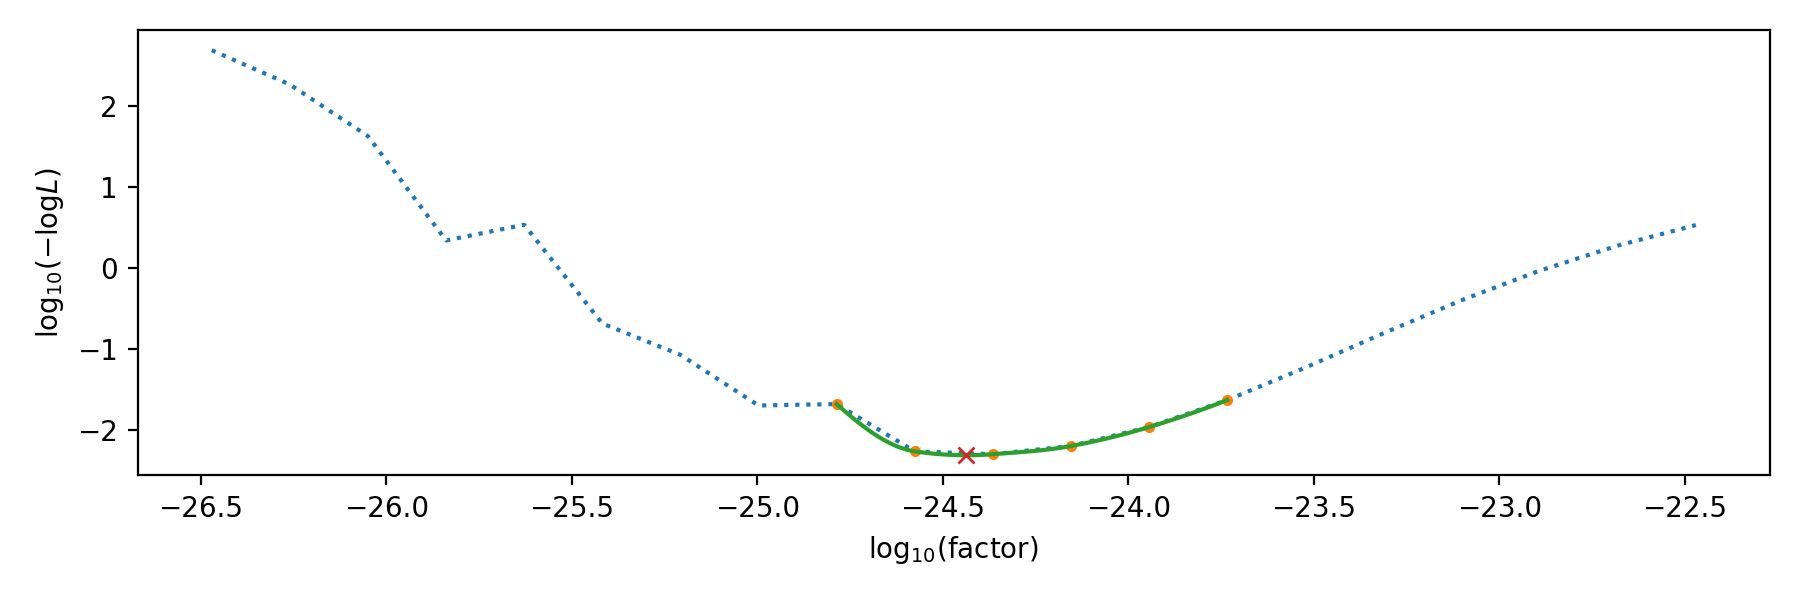

In [108]:
# Refine the grid (span 4 orders of magnitude).
best_fac = np.log10(best_fac)
factors = np.logspace(best_fac-2, best_fac+2, 20)

# No need to specify `data` and `sig` again. 
tests = extra_trpz.get_tikho_tests(factors, data=scidata, sig=uncert, tikho_kwargs=tikho_kwargs)
best_fac = extra_trpz.best_tikho_factor(tests=tests, i_plot=True)

Testing factors...
20/20


<IPython.core.display.Javascript object>


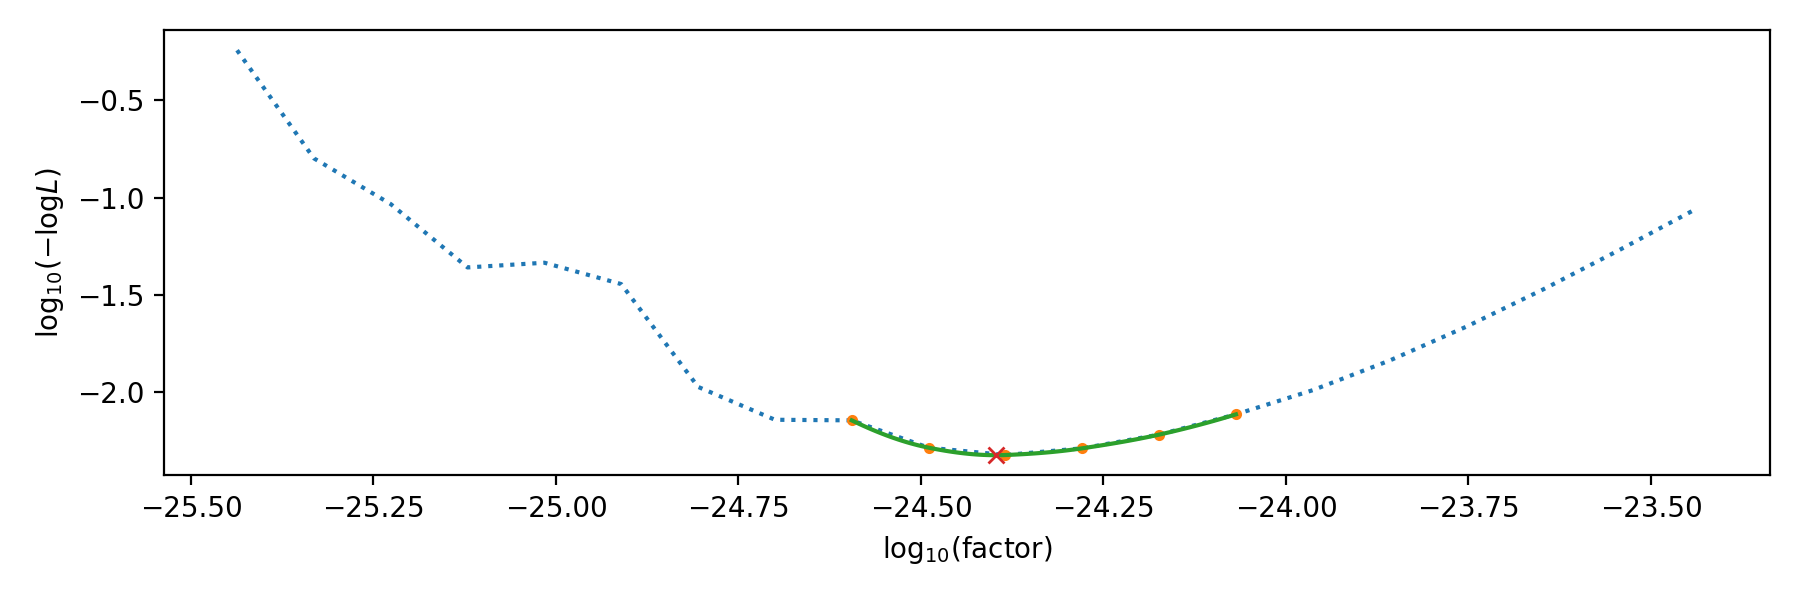

In [109]:
# Refine the grid (span 4 orders of magnitude).
best_fac = np.log10(best_fac)
factors = np.logspace(best_fac-1, best_fac+1, 20)

# No need to specify `data` and `sig` again. 
tests = extra_trpz.get_tikho_tests(factors, data=scidata, sig=uncert, tikho_kwargs=tikho_kwargs)
best_fac = extra_trpz.best_tikho_factor(tests=tests, i_plot=True)

In [69]:
best_fac, best_factor

(2.3325238705824583e-25, 2.0910250788642672e-24)

In [110]:
f_k_tikho = extra_trpz(data=scidata, tikhonov=True, factor=best_fac, tikho_kwargs=tikho_kwargs)
f_k = extra_trpz(data=scidata)

bin_center, f_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=f_k)
_, f_bin_tikho = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=f_k_tikho)

idx = (simu['grid_c1'] >= extra_trpz.lam_grid.min())  &  (simu['grid_c1'] <= extra_trpz.lam_grid.max())
_, f_bin_th = extra_trpz.bin_to_pixel(grid_pix=bin_limits,
                                      f_k_c=(simu['f_c1']*ThroughputSOSS(1)(simu['grid_c1']))[idx],
                                      grid_f_k=simu['grid_c1'][idx])

In [111]:
rebuilt = extra_trpz.rebuild(f_k_tikho)

<IPython.core.display.Javascript object>


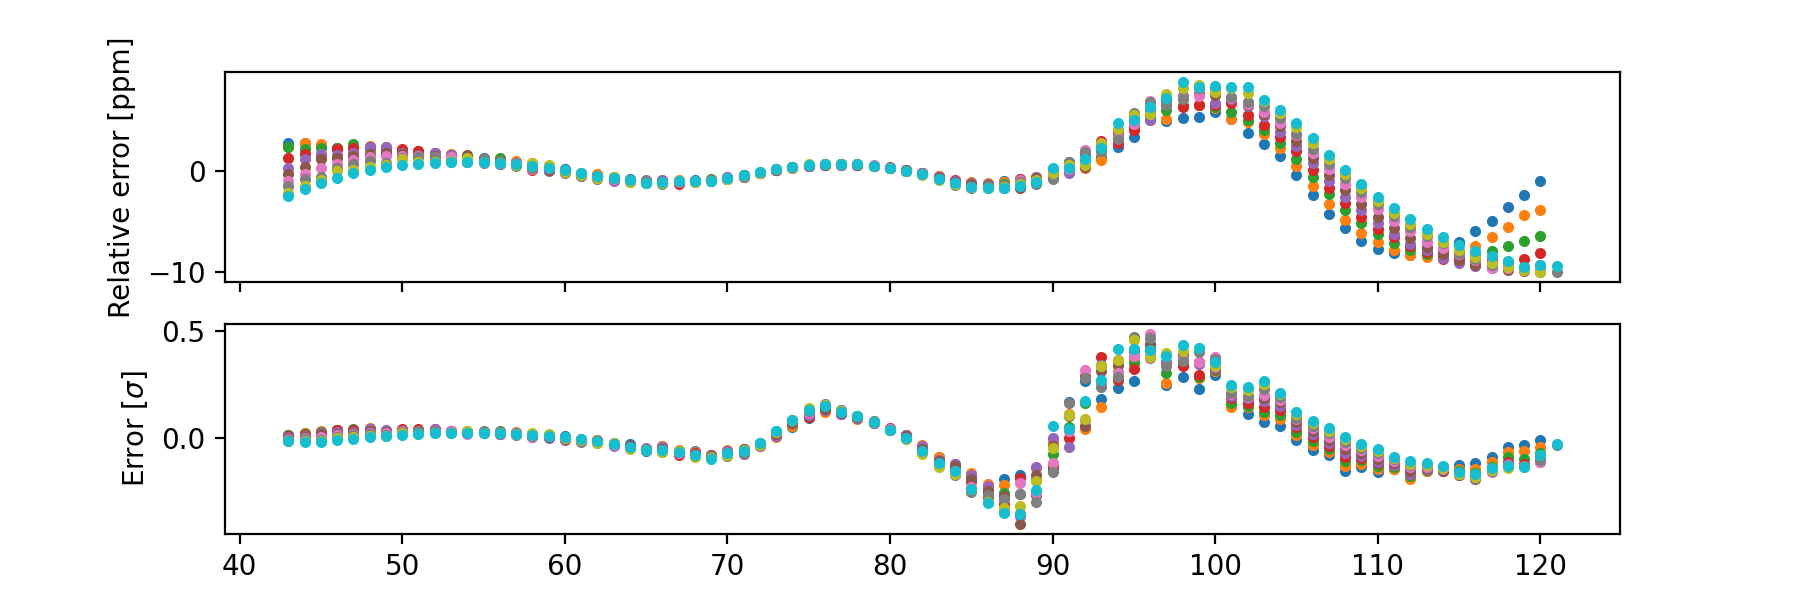

Text(0, 0.5, 'Error [$\\sigma$]')

In [114]:
fig, ax = plt.subplots(2, 1, sharex=True)
residual = (rebuilt-scidata)/scidata*1e6
for i_col in range(10,20):
    ax[0].plot(residual[:,i_col], ".")
    ax[1].plot(((rebuilt-scidata)/uncert)[:,i_col], ".")
ax[0].set_ylabel("Relative error [ppm]")
ax[1].set_ylabel("Error [$\sigma$]")

<IPython.core.display.Javascript object>


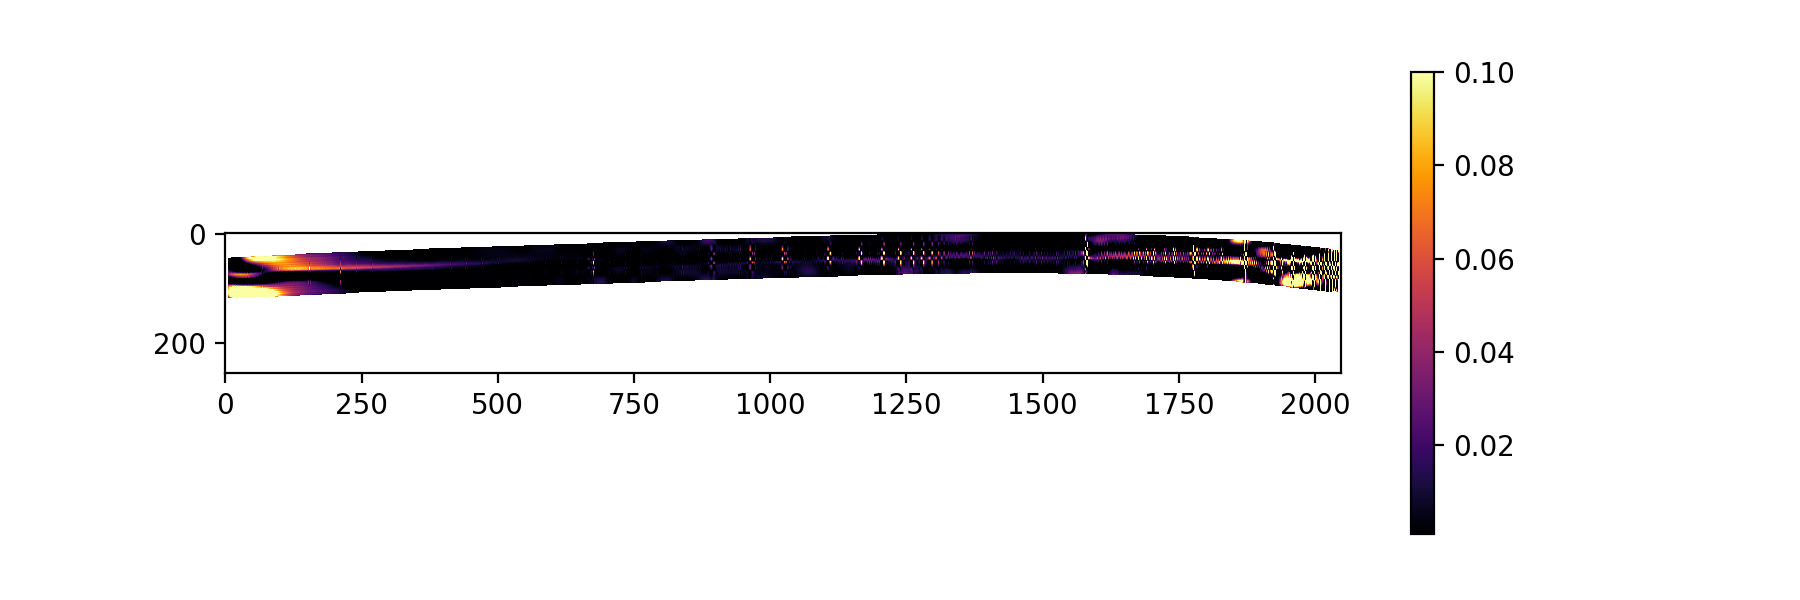

In [102]:
plt.imshow((rebuilt-scidata)/np.sqrt(scidata), vmin=0.001, vmax=0.1)
plt.colorbar()

<IPython.core.display.Javascript object>


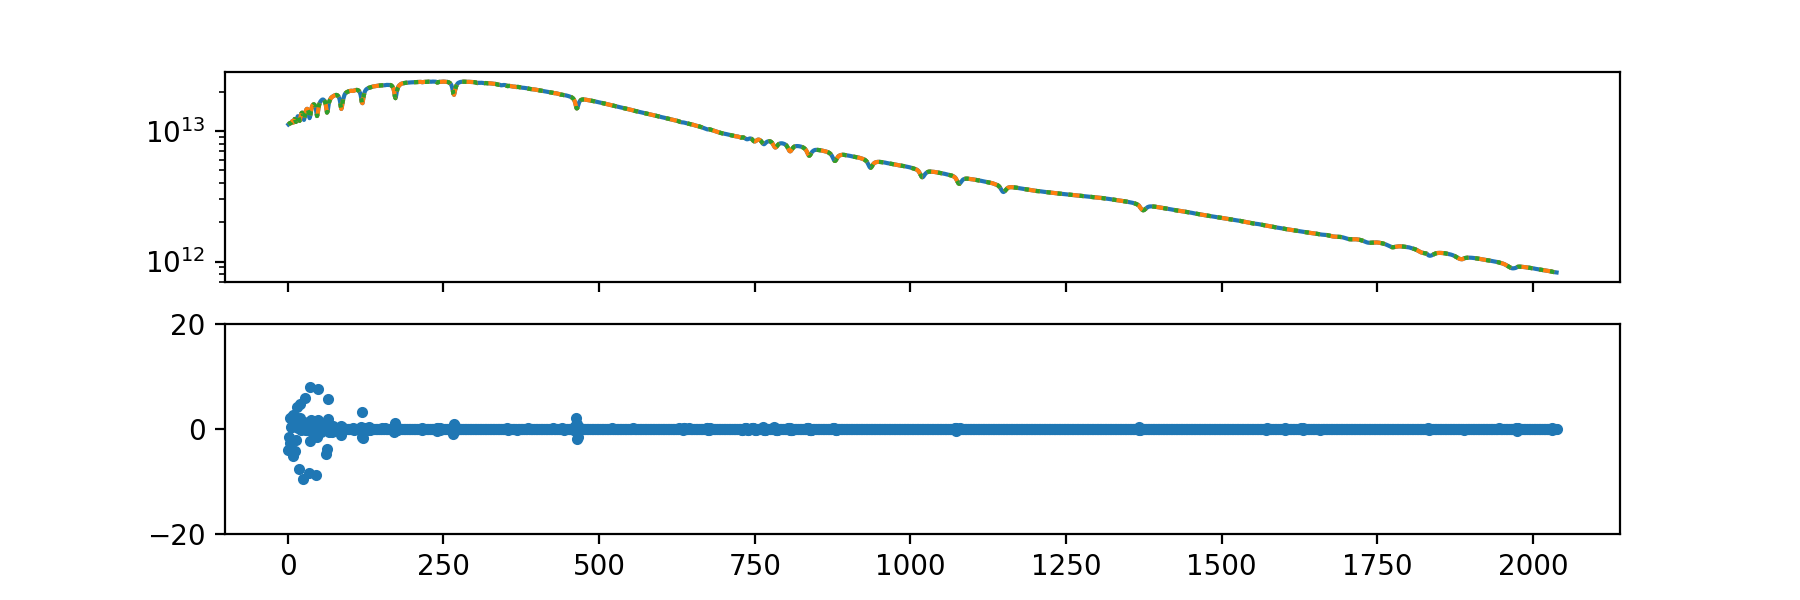

(-20.0, 20.0)

In [91]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].semilogy(f_bin_th)
ax[0].plot(f_bin, "--")
ax[0].plot(f_bin_tikho, ":")
ax[1].plot((f_bin-f_bin_th)/f_bin_th*1e6, ".")
# plt.plot((f_bin_tikho-f_bin_th)/f_bin_th*1e6, ".")
# plt.plot(f_bin_th, ":")
plt.ylim(-20,20)

<IPython.core.display.Javascript object>


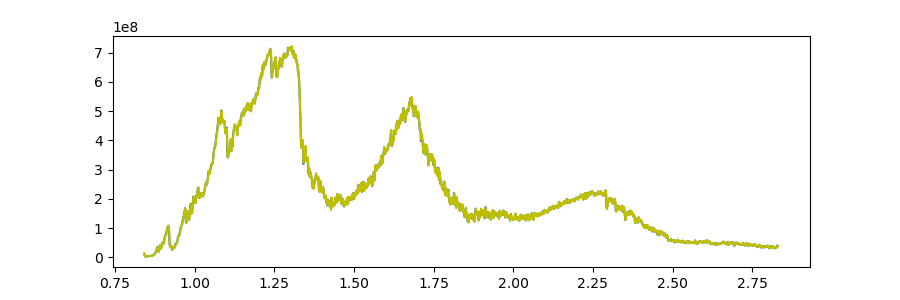

In [415]:
plt.plot(grid_box[:], f_bin[:])
plt.plot(grid_box, val_box, "y")

In [416]:
sig = np.sqrt(scidata + 20.**2)
grid_err_estim, err_estim = extra_trpz.estim_noise(sig=sig, data=scidata)

In [417]:
rel_err_estim_fct = interp1d(*extra_trpz.estim_noise(sig=sig, data=scidata),
                             bounds_error=False, fill_value=np.nan)

<IPython.core.display.Javascript object>


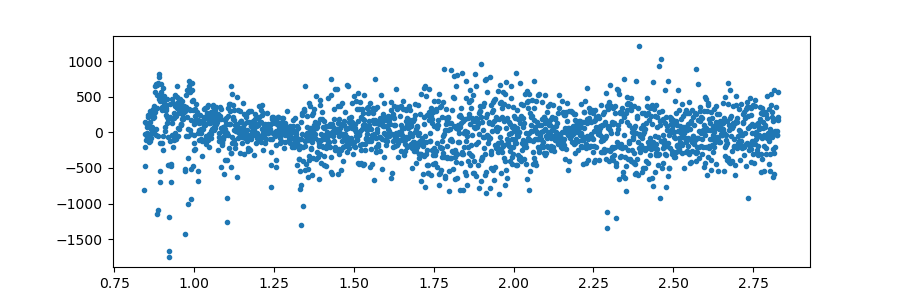

In [418]:
plt.plot(grid_box, (f_bin-val_box)/val_box / rel_err_estim_fct(grid_box), ".")

<IPython.core.display.Javascript object>


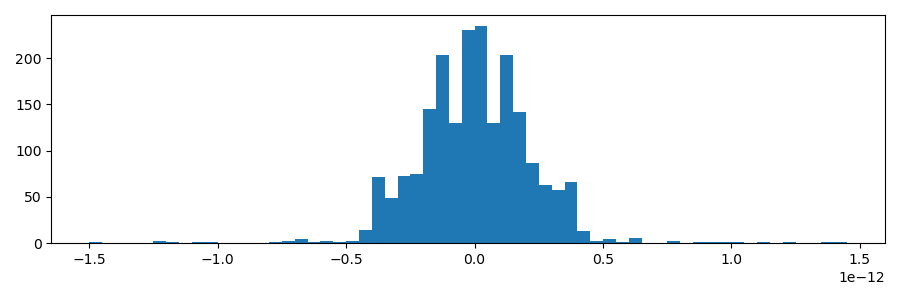

In [90]:
plt.hist((f_bin-val_box)/f_bin, bins=1e-12*np.arange(-1.5, 1.5, 0.05))
# plt.hist((f_bin-val_box)/f_bin, bins=1e-5*np.arange(-1.5, 1.5, 0.05))
# plt.hist((f_bin-val_box)/f_bin, bins=1e-2*np.arange(-3.5, 3.5, 0.1))
plt.tight_layout()

# Test stability of both extraction

In [62]:
# Load a simulation
simu_clean = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e+08_no-tilt.fits", order=1, noisy=False)

In [63]:
f_trpz_list = []
f_box_list = []

# Box
box_psf = (P1 > 1e-5)

# Trpz
# grid = grid_from_map(wv_1, P1, n_os=1)
# conv = np.array([0, 0, 1, 0, 0])
# box_psf_trpz = box_psf.astype(float)
# box_psf_trpz = box_psf_trpz / box_psf_trpz.sum(axis=0)
# box_psf_trpz[np.isnan(box_psf_trpz)] = 0.0

# TO RE DO

extra = TrpzBox(P1, wv_1)

for it in range(50):
    print(it, end="\r")
    
    scidata = add_noise(simu_clean["data"])
    
    f_k = extra.extract(data=scidata)
    
    if it == 0:
        lam_bin, f_box = box_extract(~box_psf, scidata, wv_1[50,:])
    else:
        _, f_box = box_extract(~box_psf, scidata, wv_1[50,:])
    
    _, f_trpz = extra.bin_to_pixel(f_k=f_k, grid_pix=lam_bin)
        
    f_box_list.append(f_box)
    f_trpz_list.append(f_trpz)
        


In [64]:
clean_data = simu_clean["data"]
sig = np.sqrt(clean_data + 20.**2)

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


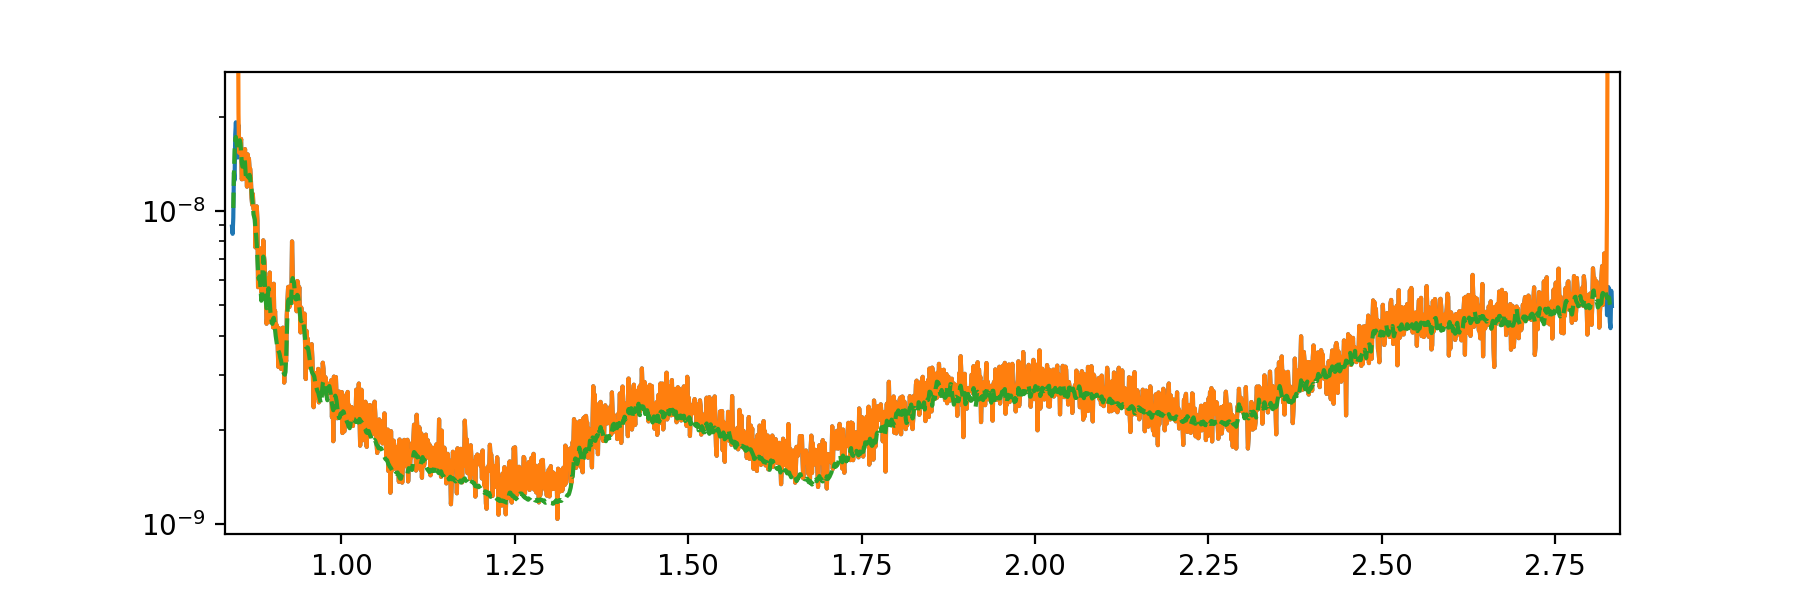

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [65]:
plt.semilogy(lam_bin, np.nanstd(f_box_list, axis=0)/np.nanmean(f_box_list, axis=0))
plt.semilogy(lam_bin, np.nanstd(f_trpz_list, axis=0)/np.nanmean(f_trpz_list, axis=0))
plt.semilogy(*extra.estim_noise(sig=sig, data=clean_data), "--")

<IPython.core.display.Javascript object>


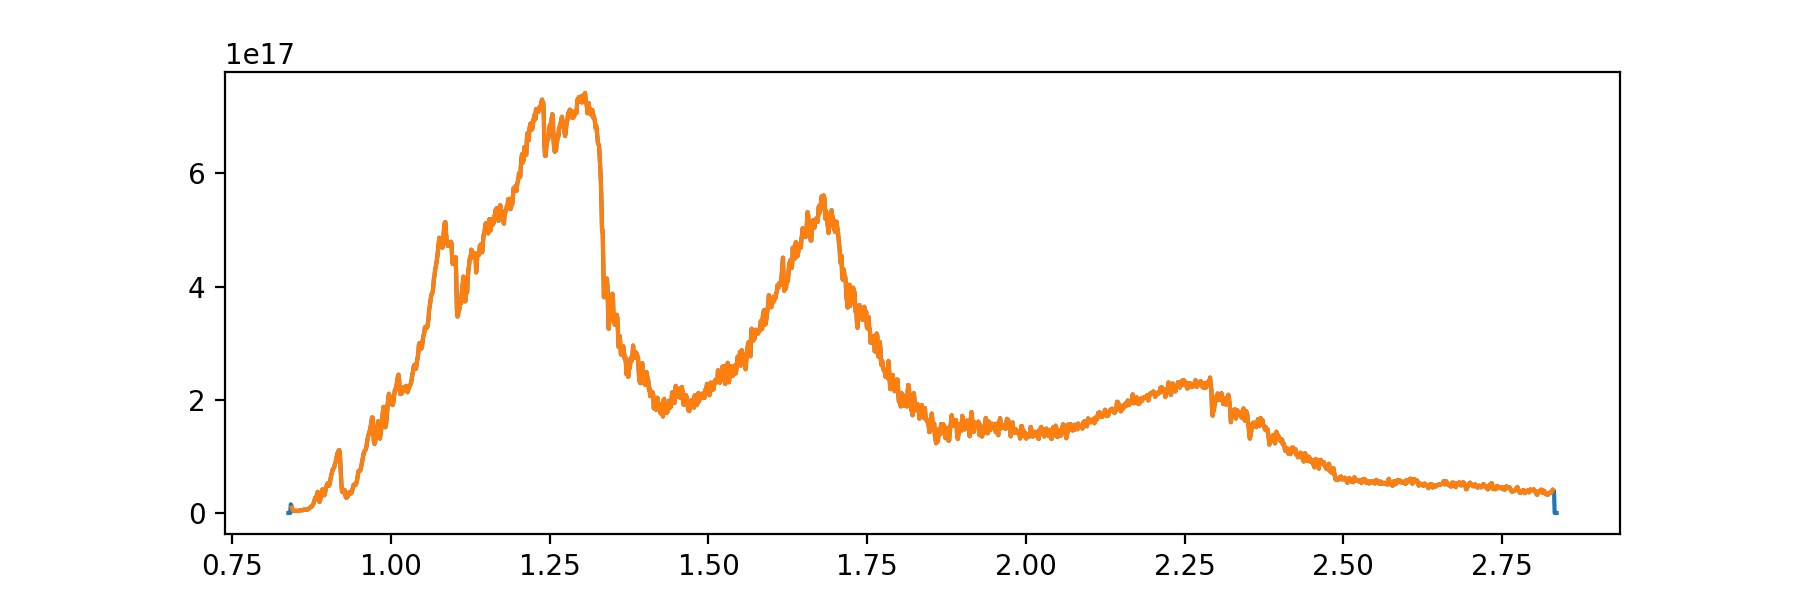

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [51]:
plt.plot(lam_bin, np.nanmean(f_box_list, axis=0))
plt.plot(lam_bin, np.nanmean(f_trpz_list, axis=0))

# Estimate error

We now that from https://stats.stackexchange.com/questions/57532/propagation-of-uncertainty-through-a-linear-system-of-equations,<br>
 if $Ax = b$ and $Var(b) = \sigma_b$, then
\begin{equation}
Var(A^{-1}b) = A^{-1}\sigma_b (A^{-1})^T
\end{equation}

In our situation, $A = B^TB$ and $b = B^TD$ where $B$ is the model of the detector and $D$ is the pixel intensity vector. Then,
\begin{equation}
Var(f) = (B^TB)^{-1} Var(B^T D) ((B^TB)^{-1})^T.
\end{equation}

In [195]:
from scipy.sparse.linalg import inv, spsolve

In [491]:
matrix, result = extra_trpz.build_sys()

In [492]:
i_grid = extra_trpz.get_i_grid(result)

In [493]:
B_T = extra_trpz.b_n_list[0][:, i_grid].T
matrix_inv = inv(matrix[i_grid,:][:,i_grid])
matrix_inv = matrix_inv.todense()

In [494]:
uncert_data = sig[~extra_trpz.mask]
var_BT = B_T.power(2).dot(uncert_data**2)

In [511]:
uncert_f = np.ones(extra_trpz.n_k) * np.nan
left = matrix_inv.dot(np.diag(var_BT))
# test = left.dot(matrix_inv.T)
uncert_f[i_grid] = np.sqrt(left.dot(matrix_inv.T).diagonal())

In [505]:
# Test simple A dx = db
uncert_f = np.ones(extra_trpz.n_k) * np.nan
uncert_result = np.sqrt(var_BT)
uncert_f[i_grid] = spsolve(matrix[i_grid,:][:,i_grid], uncert_result)

<IPython.core.display.Javascript object>


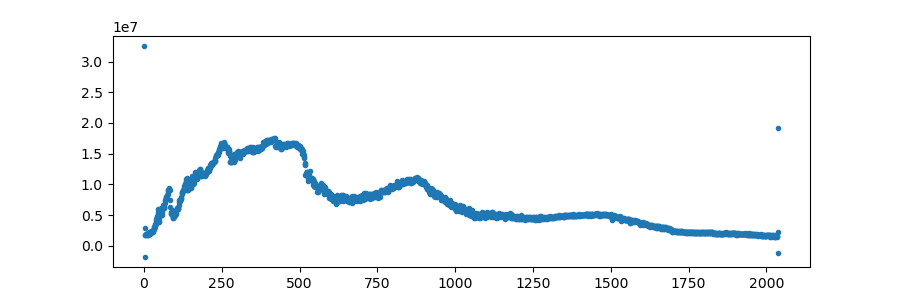

In [506]:
plt.plot(uncert_f, ".")

In [425]:
f_k = extra_trpz()

<IPython.core.display.Javascript object>


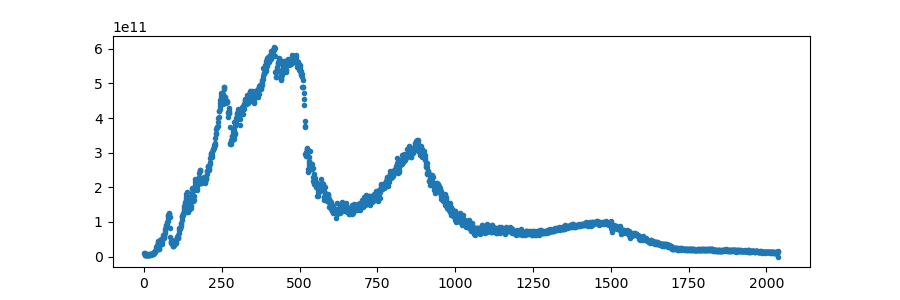

In [426]:
plt.plot(f_k, ".")

In [497]:
lam_p, lam_m = get_lam_p_or_m(extra_trpz.lam_grid)
lam_p, lam_m = np.sort(lam_p), np.sort(lam_m)
grid_trpz = np.concatenate([lam_m, [lam_p[-1]]])

bin_limits = [lam_m, lam_p]

In [498]:
cancel_lambda = interp1d(extra_trpz.lam_grid, 1/extra_trpz.lam_grid)

_, uncert_f_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=uncert_f)
_, test_uncert_f_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=uncert_f, throughput=cancel_lambda)
_, f_bin = extra_trpz.bin_to_pixel(grid_pix=bin_limits, f_k=f_k)

<IPython.core.display.Javascript object>


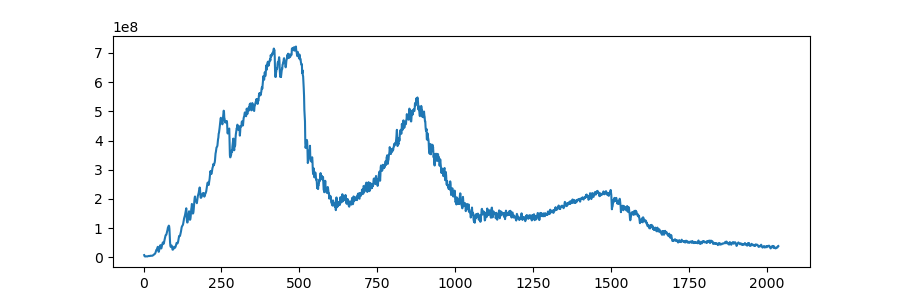

In [455]:
plt.plot(f_bin)

<IPython.core.display.Javascript object>


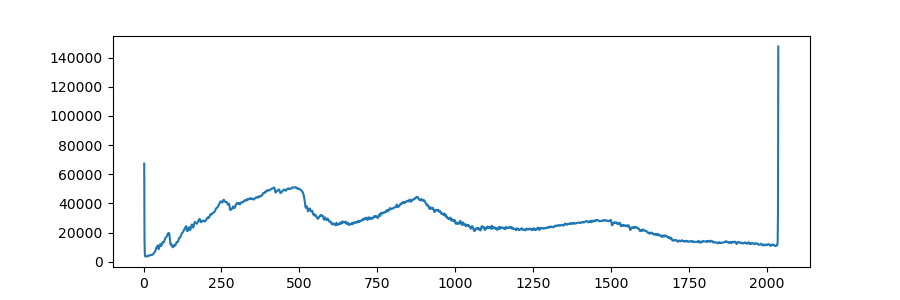

In [499]:
plt.plot(uncert_f_bin)
# plt.plot(rel_err_estim_fct(grid_box)*f_bin)

<IPython.core.display.Javascript object>


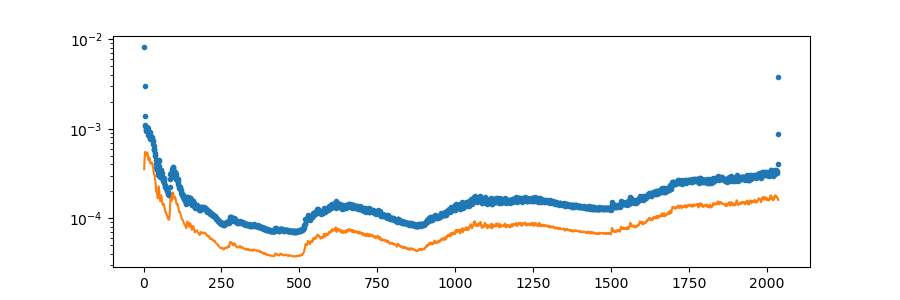

In [500]:
plt.semilogy(uncert_f_bin/f_bin, ".")
plt.semilogy(rel_err_estim_fct(extra_trpz.lam_grid))
# plt.plot(test_uncert_f_bin)
# plt.ylim(0, 4000000)


<IPython.core.display.Javascript object>


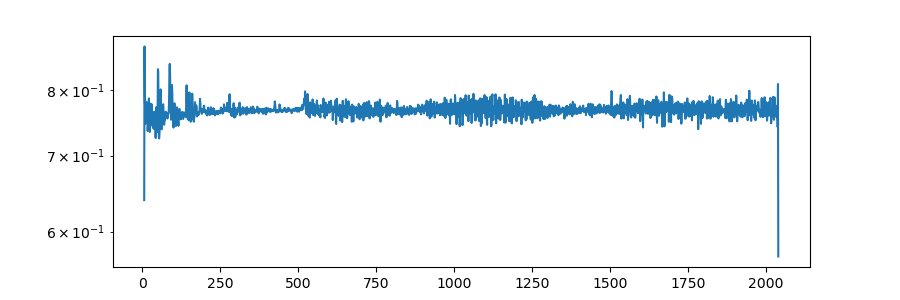

In [431]:
plt.semilogy(uncert_f_bin/f_bin/rel_err_estim_fct(grid_box))

## Empirical error estimate

In [433]:
# Load a simulation
simu_clean = load_simu("../Simulations/phoenix_teff_02300_scale_1.0e-01.fits", order=1, noisy=False)

In [459]:
f_trpz_list = []

for it in range(50):
    print(it, end="\r")
    
    scidata = add_noise(simu_clean["data"])
    
    f_k = extra_trpz.extract(data=scidata)
    
    _, f_trpz = extra_trpz.bin_to_pixel(f_k=f_k, grid_pix=bin_limits)

    f_trpz_list.append(f_trpz)
        


In [460]:
sig = np.sqrt(scidata + 20.**2)

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


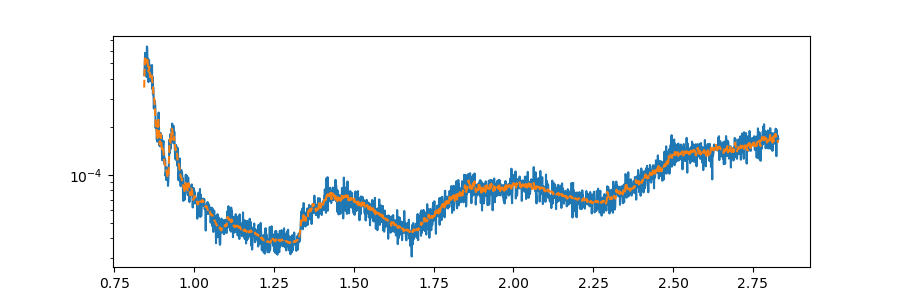

In [461]:
plt.semilogy(extra_trpz.lam_grid, np.nanstd(f_trpz_list, axis=0)/np.nanmean(f_trpz_list, axis=0))
plt.semilogy(*extra_trpz.estim_noise(sig=sig, data=scidata), "--")

# TESTS

In [462]:
TrpzOverlap?

In [463]:
extra_trpz.lam_grid.shape

(2040,)

In [502]:
uncert_f.shape

(2040,)

In [478]:
n_bin = extra_trpz.lam_grid.size
integration = TrpzBox(np.ones((1, n_bin)), extra_trpz.lam_grid[None, :], lam_grid=extra_trpz.lam_grid)

<IPython.core.display.Javascript object>


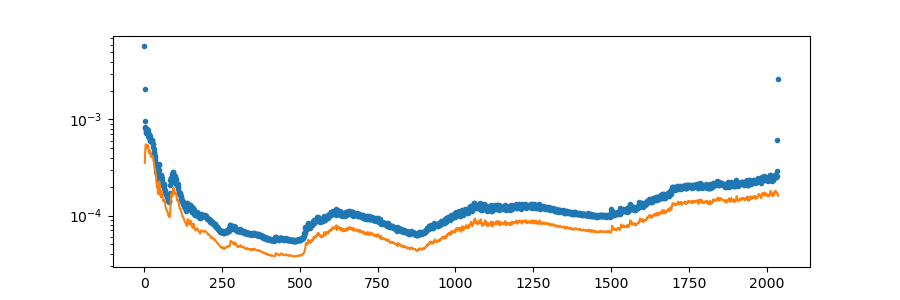

In [512]:
plt.semilogy(np.sqrt(integration.get_b_n(0).power(2).dot(uncert_f**2))/f_bin[2:-2], ".")
plt.semilogy(rel_err_estim_fct(extra_trpz.lam_grid))

In [451]:
f_k_spl = UnivariateSpline(extra_trpz.lam_grid[i_grid], f_k[i_grid], k=1, s=0)

<IPython.core.display.Javascript object>


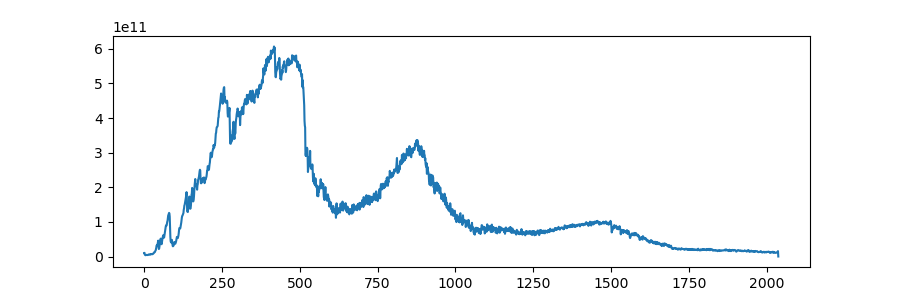

In [452]:
plt.plot(f_k_spl.get_coeffs())